In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import glob
import time
from random import shuffle
from collections import Counter

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

pic_size = 64
batch_size = 32
epochs = 200
num_classes = len(map_characters)
pictures_per_class = 1000
test_size = 0.15

def load_pictures(BGR):
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """
    pics = []
    labels = []
    for k, char in map_characters.items():
        pictures = [k for k in glob.glob('./simpsons_dataset/%s/*' % char)]
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)
        print(nb_pic)
        # nb_pic = len(pictures)
        for pic in np.random.choice(pictures, nb_pic):
            a = cv2.imread(pic)
            if BGR:
                a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            a = cv2.resize(a, (pic_size,pic_size))
            pics.append(a)
            labels.append(k)
    return np.array(pics), np.array(labels) 

def get_dataset(save=False, load=False, BGR=False):
    """
    Create the actual dataset split into train and test, pictures content is as float32 and
    normalized (/255.). The dataset could be saved or loaded from h5 files.
    :param save: saving or not the created dataset
    :param load: loading or not the dataset
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: X_train, X_test, y_train, y_test (numpy arrays)
    """
    '''if load:
        h5f = h5py.File('dataset.h5','r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()    

        h5f = h5py.File('labels.h5','r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()    '''
    #else:
    X, y = load_pictures(BGR)
    print(X.shape)
    y = keras.utils.to_categorical(y, num_classes)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)
    if not load:
        dist = {k:tuple(d[k] for d in [dict(Counter(np.where(y_train==1)[1])), dict(Counter(np.where(y_test==1)[1]))]) 
                for k in range(num_classes)}
        print('\n'.join(["%s : %d train pictures & %d test pictures" % (map_characters[k], v[0], v[1]) 
            for k,v in sorted(dist.items(), key=lambda x:x[1][0], reverse=True)]))
    return X_train, X_test, y_train, y_test

def create_model_four_conv(input_shape):
    """
    CNN Keras model with 4 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    return model, opt

def create_model_six_conv(input_shape):
    """
    CNN Keras model with 6 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    return model, opt

def load_model_from_checkpoint(weights_path, six_conv=False, input_shape=(pic_size,pic_size,3)):
    if six_conv:
        model, opt = create_model_six_conv(input_shape)
    else:
        model, opt = create_model_four_conv(input_shape)
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model


def lr_schedule(epoch):
    lr = 0.01
    return lr*(0.1**int(epoch/10))

def training(model, X_train, X_test, y_train, y_test, data_augmentation=True):
    """
    Training.
    :param model: Keras sequential model
    :param data_augmentation: boolean for data_augmentation (default:True)
    :param callback: boolean for saving model checkpoints and get the best saved model
    :param six_conv: boolean for using the 6 convs model (default:False, so 4 convs)
    :return: model and epochs history (acc, loss, val_acc, val_loss for every epoch)
    """
    if data_augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(X_train)
        filepath="weights_6conv_%s.hdf5" % time.strftime("%d%m/%Y")
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
        history = model.fit_generator(datagen.flow(X_train, y_train,
                                    batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0] // batch_size,
                                    epochs=30,
                                    validation_data=(X_test, y_test),
                                    callbacks=callbacks_list)        
    else:
        history = model.fit(X_train,  y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)
    return model, history

if __name__ == '__main__':
    X_train, X_test, y_train, y_test = get_dataset(load=True)
    model, opt = create_model_six_conv(X_train.shape[1:])
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    model, history = training(model, X_train, X_test, y_train, y_test, data_augmentation=True)

913
623
1176
1176
986
469
457
1176
498
1176
1176
1176
1079
1176
1176
358
1176
877
(16844, 64, 64, 3)
Train (14317, 64, 64, 3) (14317, 18)
Test (2527, 64, 64, 3) (2527, 18)
Epoch 1/30
447/447 [==============================] - 661s 1s/step - loss: 2.6357 - accuracy: 0.1644 - val_loss: 2.2525 - val_accuracy: 0.2758
Epoch 2/30


/Users/chintu/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


447/447 [==============================] - 644s 1s/step - loss: 2.0580 - accuracy: 0.3650 - val_loss: 1.6289 - val_accuracy: 0.4907
Epoch 3/30
447/447 [==============================] - 607s 1s/step - loss: 1.5808 - accuracy: 0.5172 - val_loss: 1.1128 - val_accuracy: 0.6636
Epoch 4/30
447/447 [==============================] - 619s 1s/step - loss: 1.2469 - accuracy: 0.6242 - val_loss: 0.9883 - val_accuracy: 0.6834
Epoch 5/30
447/447 [==============================] - 618s 1s/step - loss: 0.9832 - accuracy: 0.7001 - val_loss: 0.6873 - val_accuracy: 0.8053
Epoch 6/30
447/447 [==============================] - 618s 1s/step - loss: 0.8267 - accuracy: 0.7497 - val_loss: 0.5178 - val_accuracy: 0.8429
Epoch 7/30
447/447 [==============================] - 657s 1s/step - loss: 0.7006 - accuracy: 0.7891 - val_loss: 0.4520 - val_accuracy: 0.8587
Epoch 8/30
447/447 [==============================] - 648s 1s/step - loss: 0.6098 - accuracy: 0.8165 - val_loss: 0.4499 - val_accuracy: 0.8706
Epoch 9/30

In [8]:
model.evaluate(X_test,y_test,batch_size=32)

2527/2527 [==============================] - 27s 11ms/step


[0.18139322630494986, 0.950138509273529]

In [145]:
url = "./kaggle_simpson_testset/kaggle_simpson_testset/principal_skinner_43.jpg"

In [152]:
def url_to_image(url):
    #resp = urllib.request.urlopen(url)
    #print(resp)
    with open(url,'rb') as image:
        f= image.read()
        image=np.asarray(bytearray(f),dtype="uint8")
    #image = np.asarray(bytearray(img.read()), dtype="uint8")
    #print(image)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    #print(image)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict_proba(pic.reshape(1, pic_size, pic_size,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

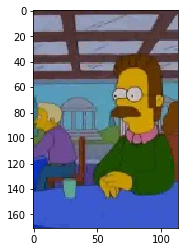

'Ned Flanders'

In [153]:
url = "./kaggle_simpson_testset/kaggle_simpson_testset/ned_flanders_32.jpg"
plot_and_predict(url)

In [156]:
y_pred = model.predict(X_test)

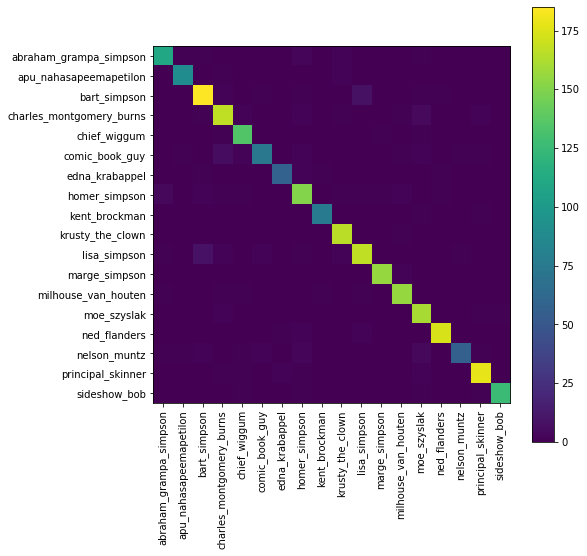

In [158]:
import sklearn
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [159]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.93      0.94       118
  apu_nahasapeemapetilon       0.97      0.97      0.97        93
            bart_simpson       0.92      0.93      0.93       199
charles_montgomery_burns       0.91      0.92      0.92       181
            chief_wiggum       0.94      0.98      0.96       138
          comic_book_guy       0.94      0.82      0.88        90
          edna_krabappel       0.95      0.92      0.94        63
           homer_simpson       0.89      0.92      0.90       165
           kent_brockman       0.97      0.97      0.97        78
        krusty_the_clown       0.95      0.99      0.97       167
            lisa_simpson       0.93      0.90      0.92       185
           marge_simpson       0.99      0.99      0.99       158
     milhouse_van_houten       0.96      0.97      0.96       161
             moe_szyslak       0.90      0.98      0.94       165
        

In [15]:
target_size=(64, 64)
def preprocess_image(img_path, model=None, rescale=255, resize=(64, 64)):
    """
    Preprocesses a given image for prediction with a trained model, with rescaling and resizing options
    
    Arguments:
            img_path: The path to the image file
            rescale: A float or integer indicating required rescaling. 
                    The image array will be divided (scaled) by this number.
            resize: A tuple indicating desired target size. 
                    This should match the input shape as expected by the model
    Returns:
            img: A processed image.
    """
    from keras.preprocessing.image import img_to_array, load_img
    import cv2
    import numpy as np

    assert type(img_path) == str, "Image path must be a string"
    assert (
        type(rescale) == int or type(rescale) == float
    ), "Rescale factor must be either a float or int"
    assert (
        type(resize) == tuple and len(resize) == 2
    ), "Resize target must be a tuple with two elements"

    img = load_img(img_path)
    img = img_to_array(img)
    img = img / float(rescale)
    img = cv2.resize(img, resize)
    if model != None:
        if len(model.input_shape) == 4:
            img = np.expand_dims(img, axis=0)

    return img

In [20]:
from keract import display_activations
# The image path
#img_path = '../images/brain-1.jpg'
img_path  = './abraham_grampa_simpson/pic_0000.jpg'
# Preprocessing the image for the model
x = preprocess_image(img_path=img_path,model=model,resize=target_size)
# Generate the activations 
activations = get_activations(model, x)

In [13]:
from keract import get_activations

conv2d_1/BiasAdd:0 (1, 64, 64, 32) 


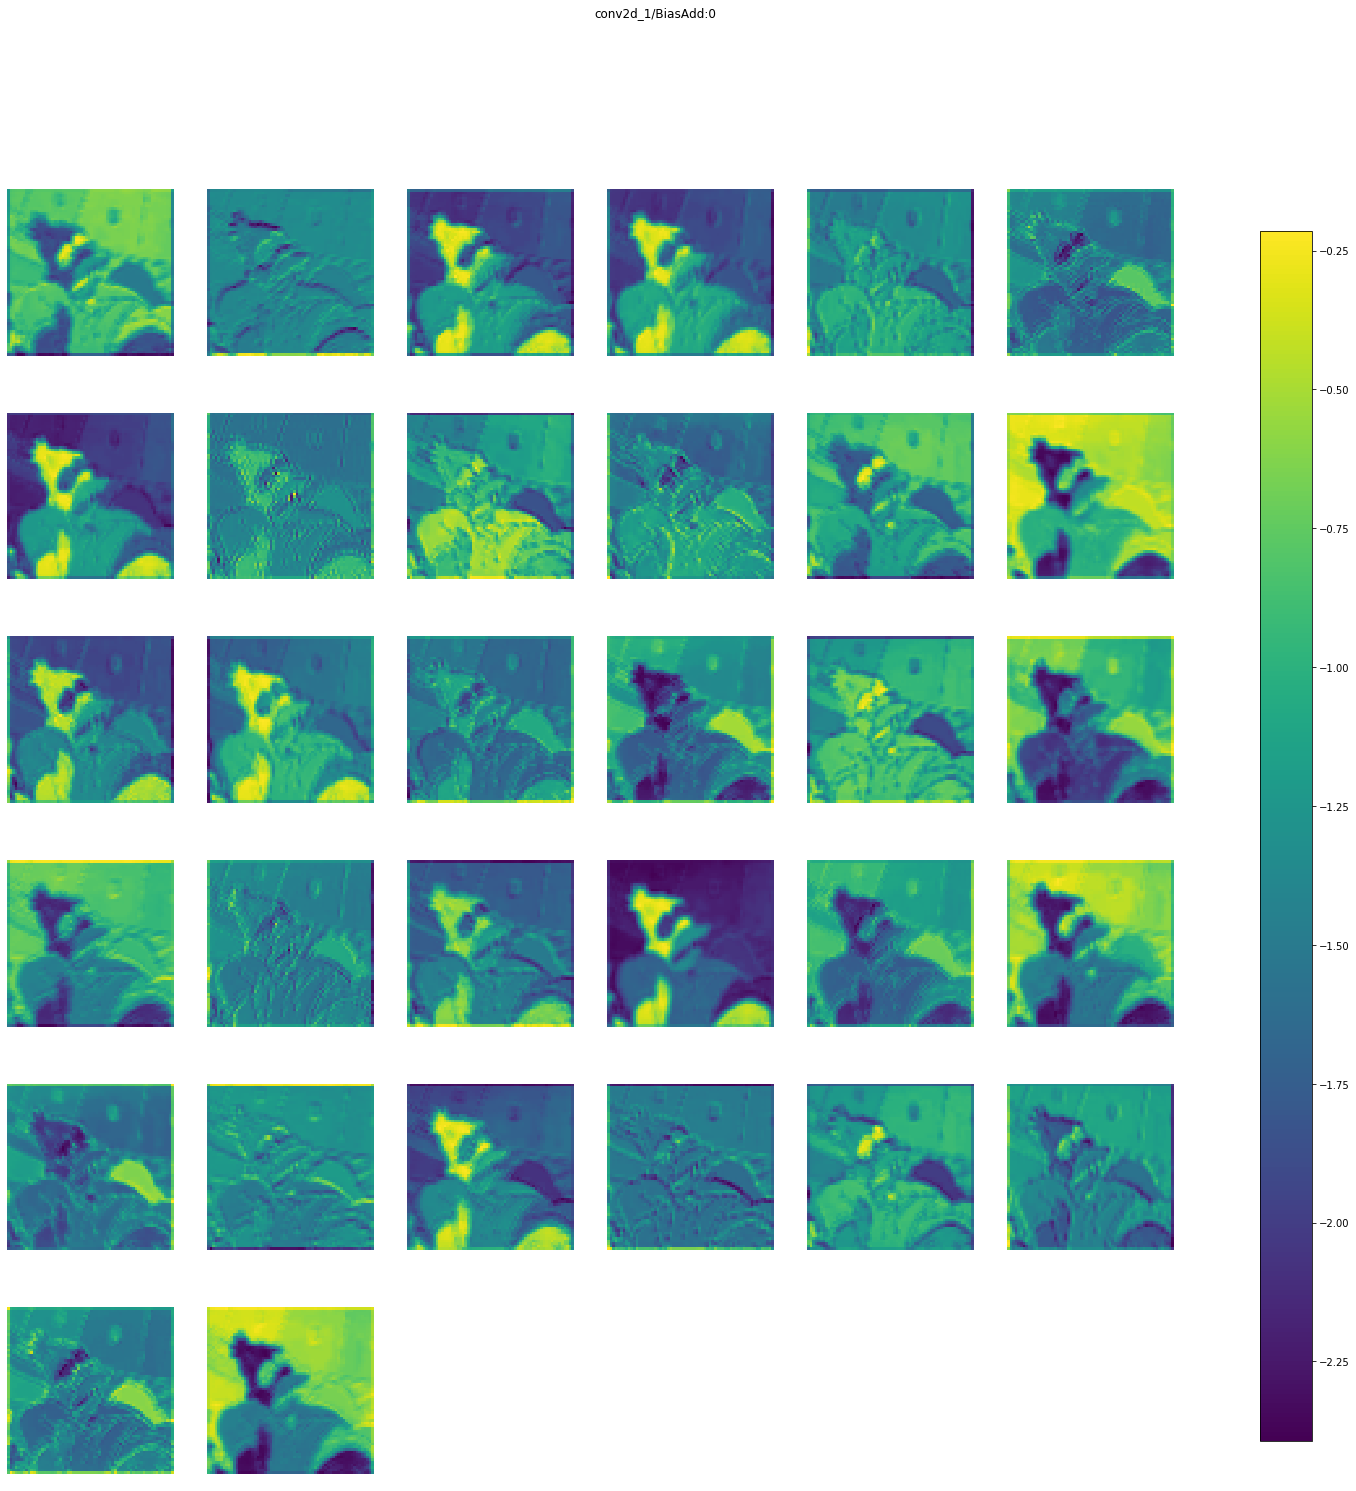

activation_1/Relu:0 (1, 64, 64, 32) 


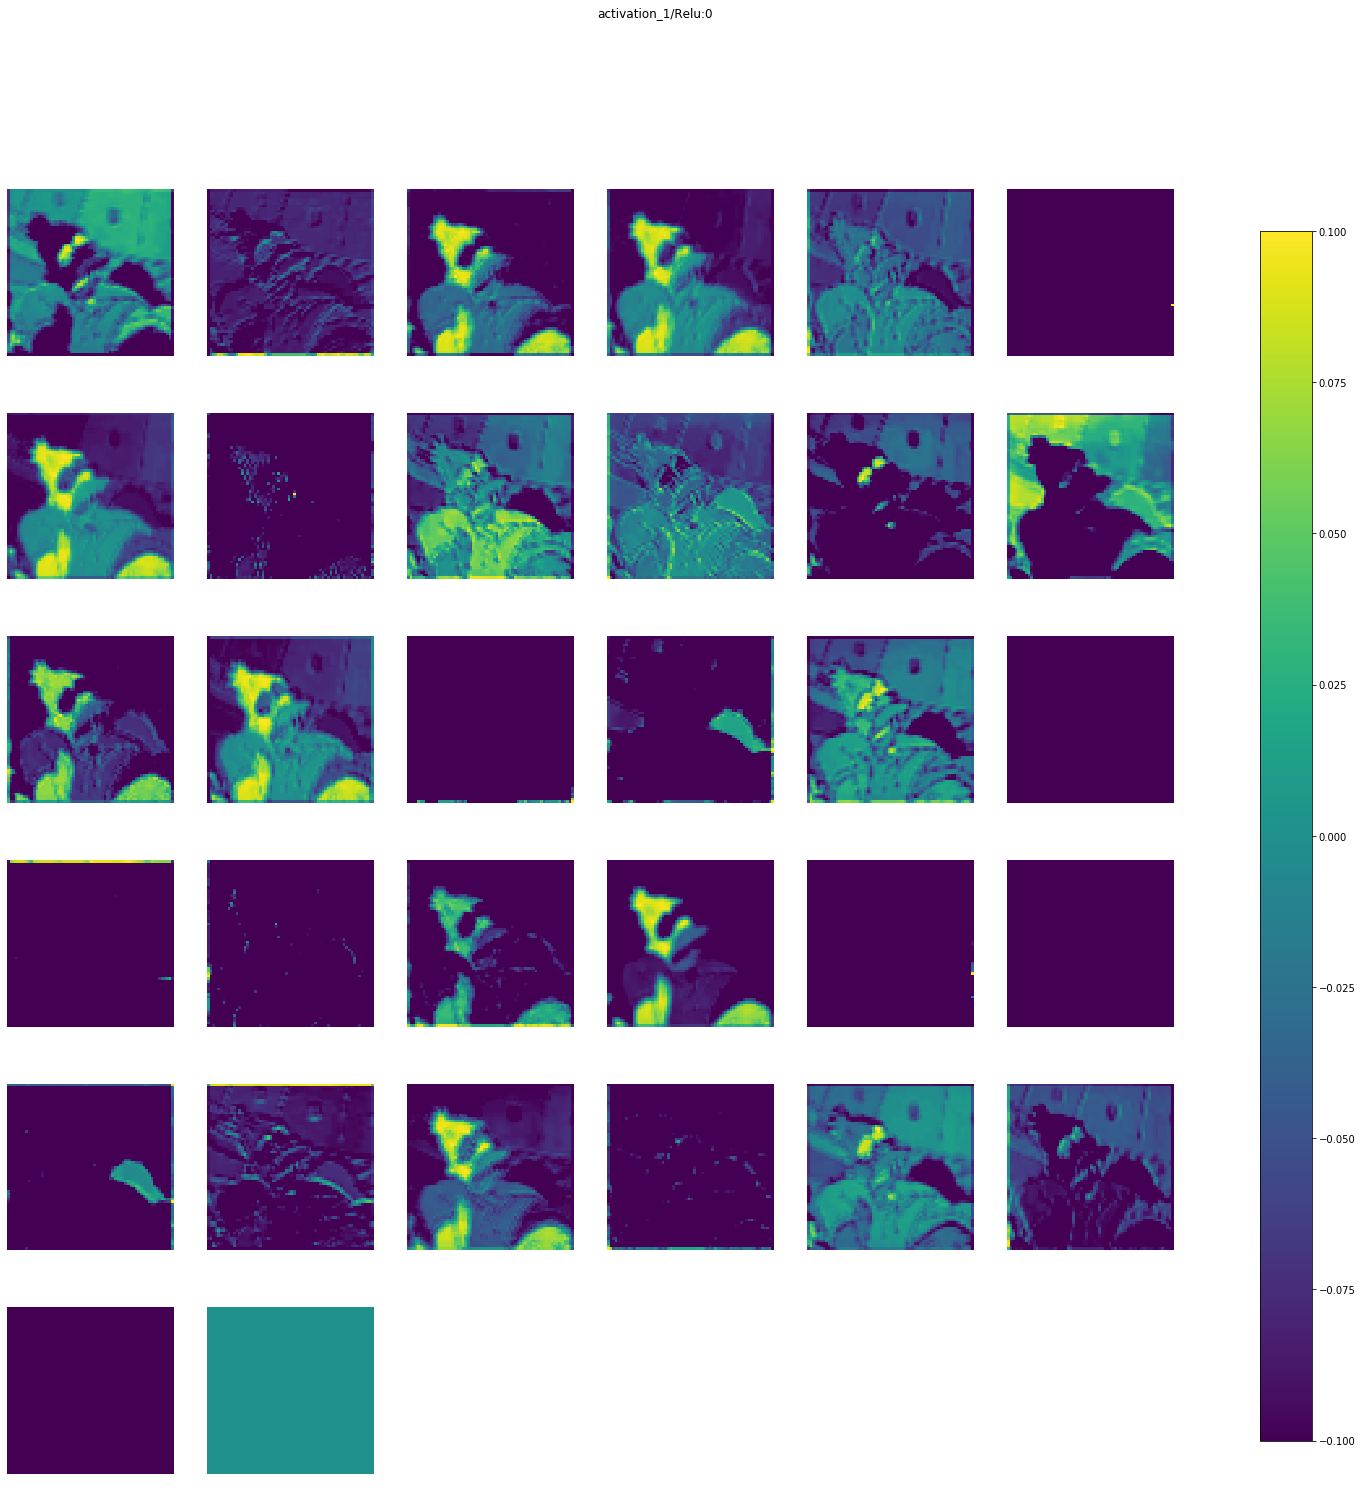

conv2d_2/BiasAdd:0 (1, 62, 62, 32) 


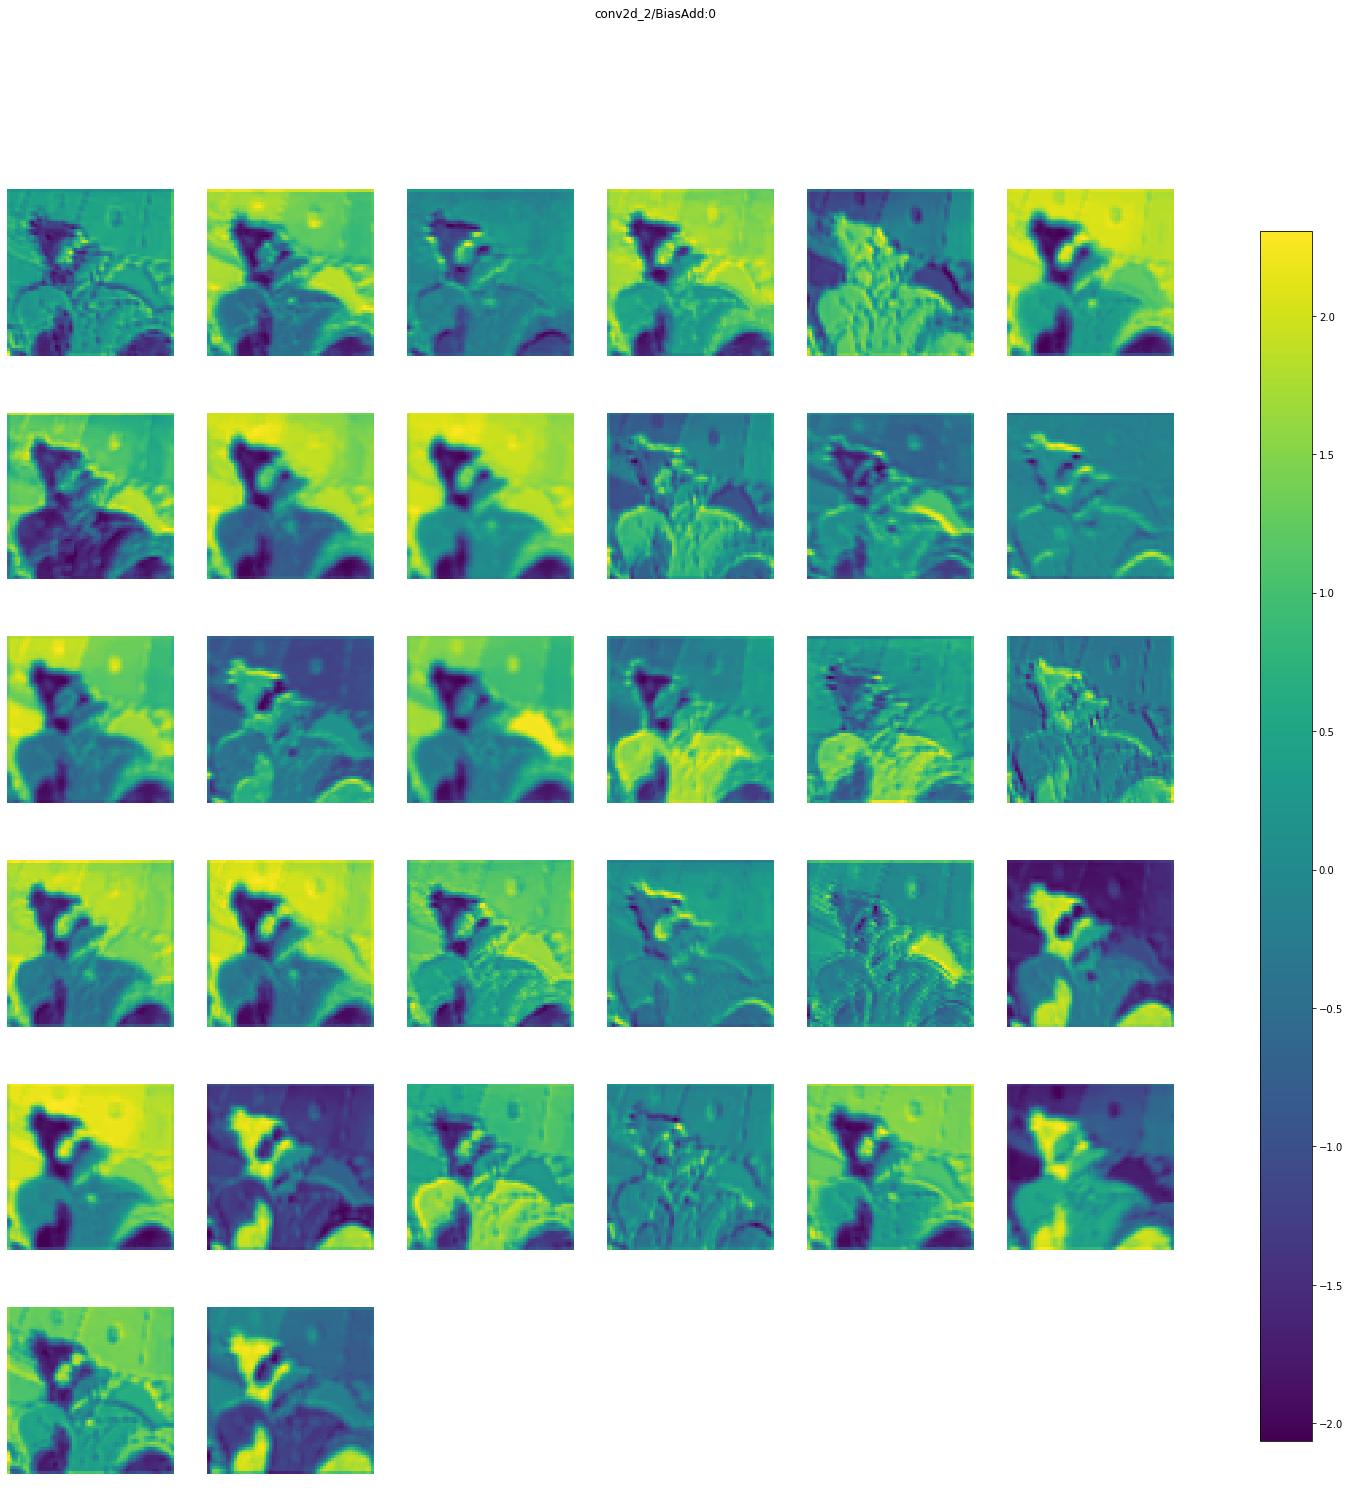

activation_2/Relu:0 (1, 62, 62, 32) 


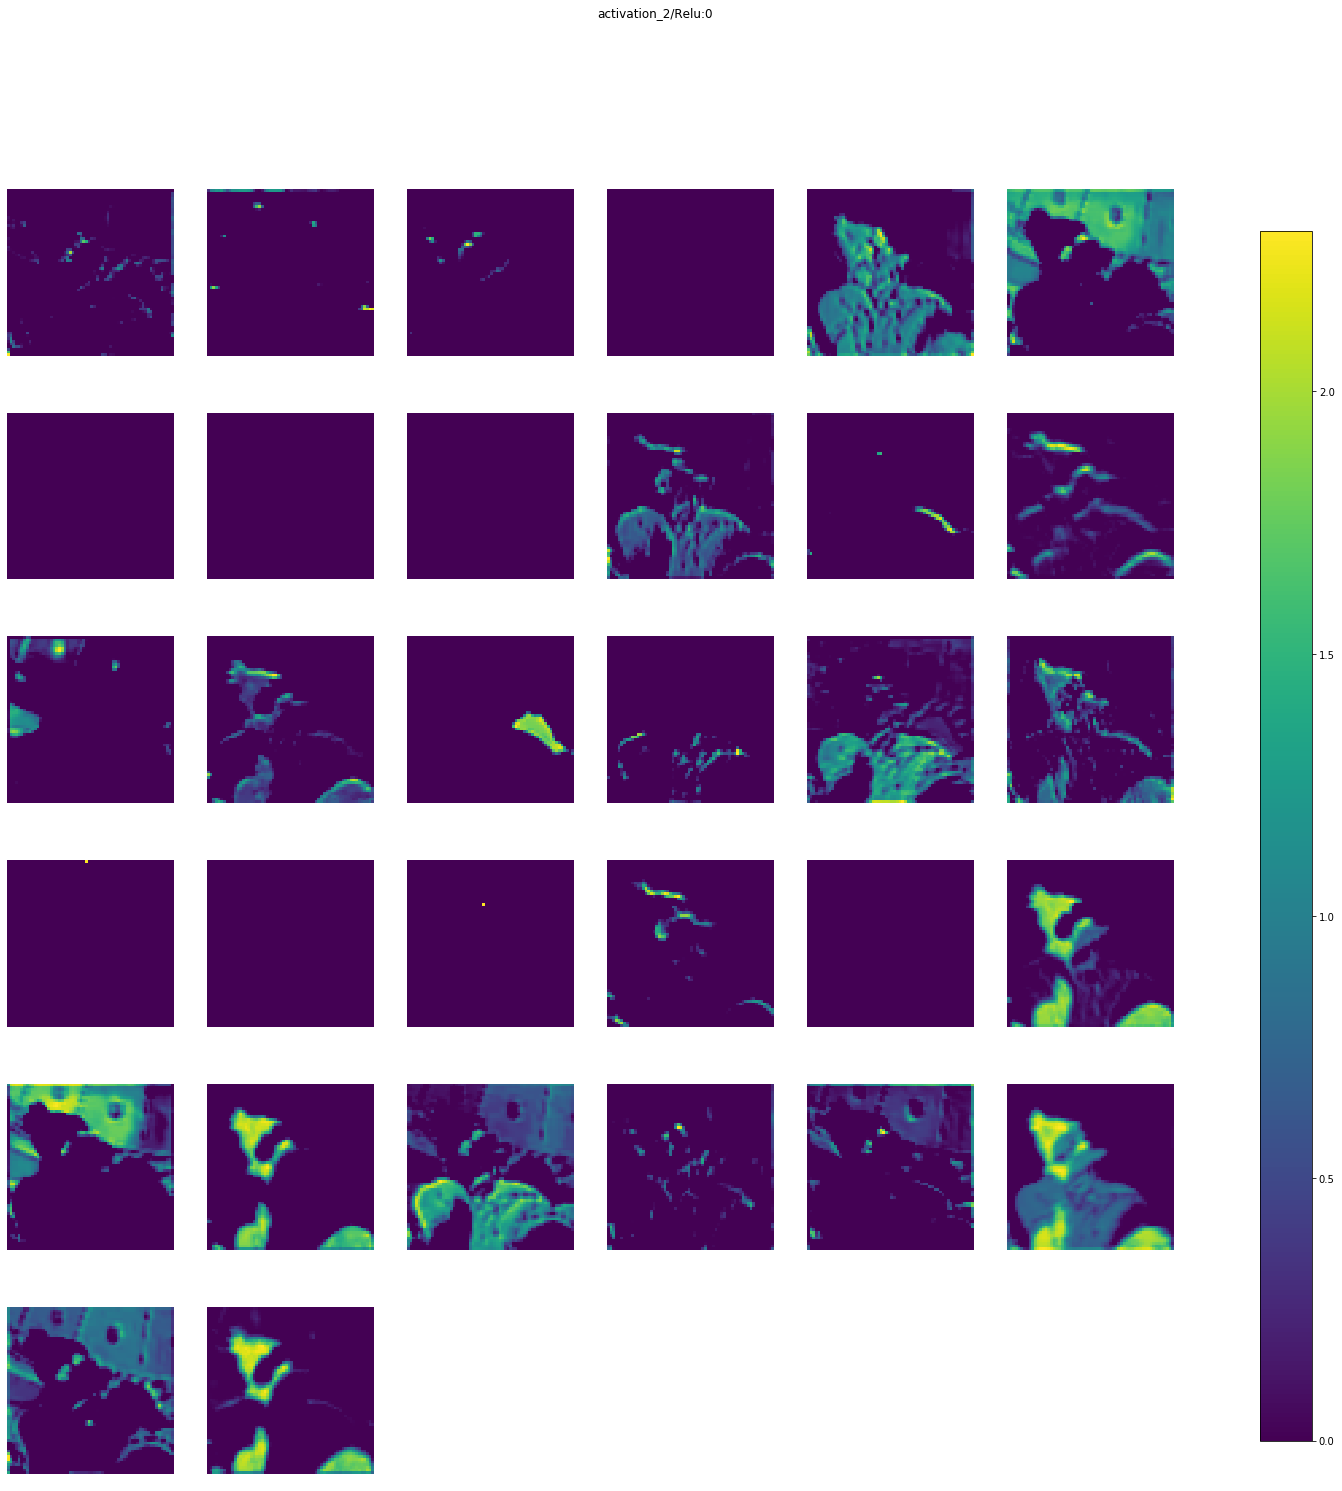

max_pooling2d_1/MaxPool:0 (1, 31, 31, 32) 


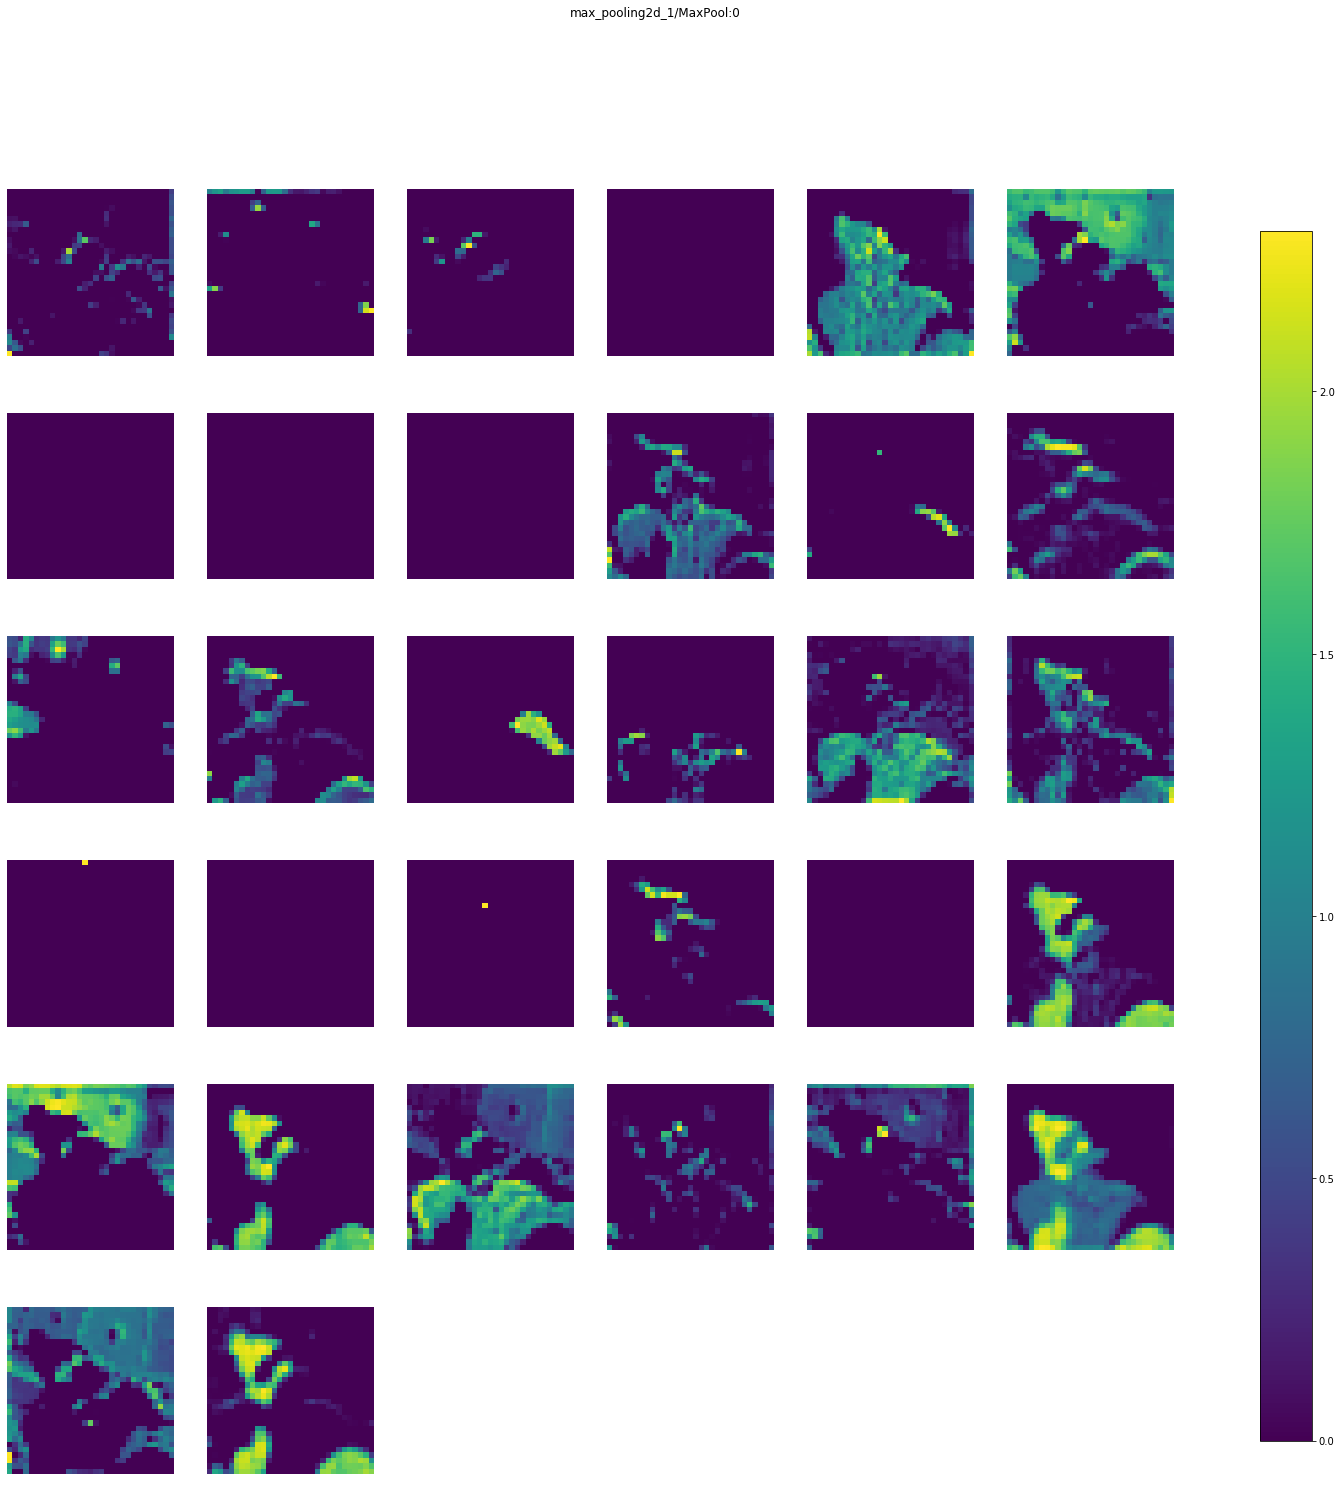

dropout_1/cond/Identity:0 (1, 31, 31, 32) 


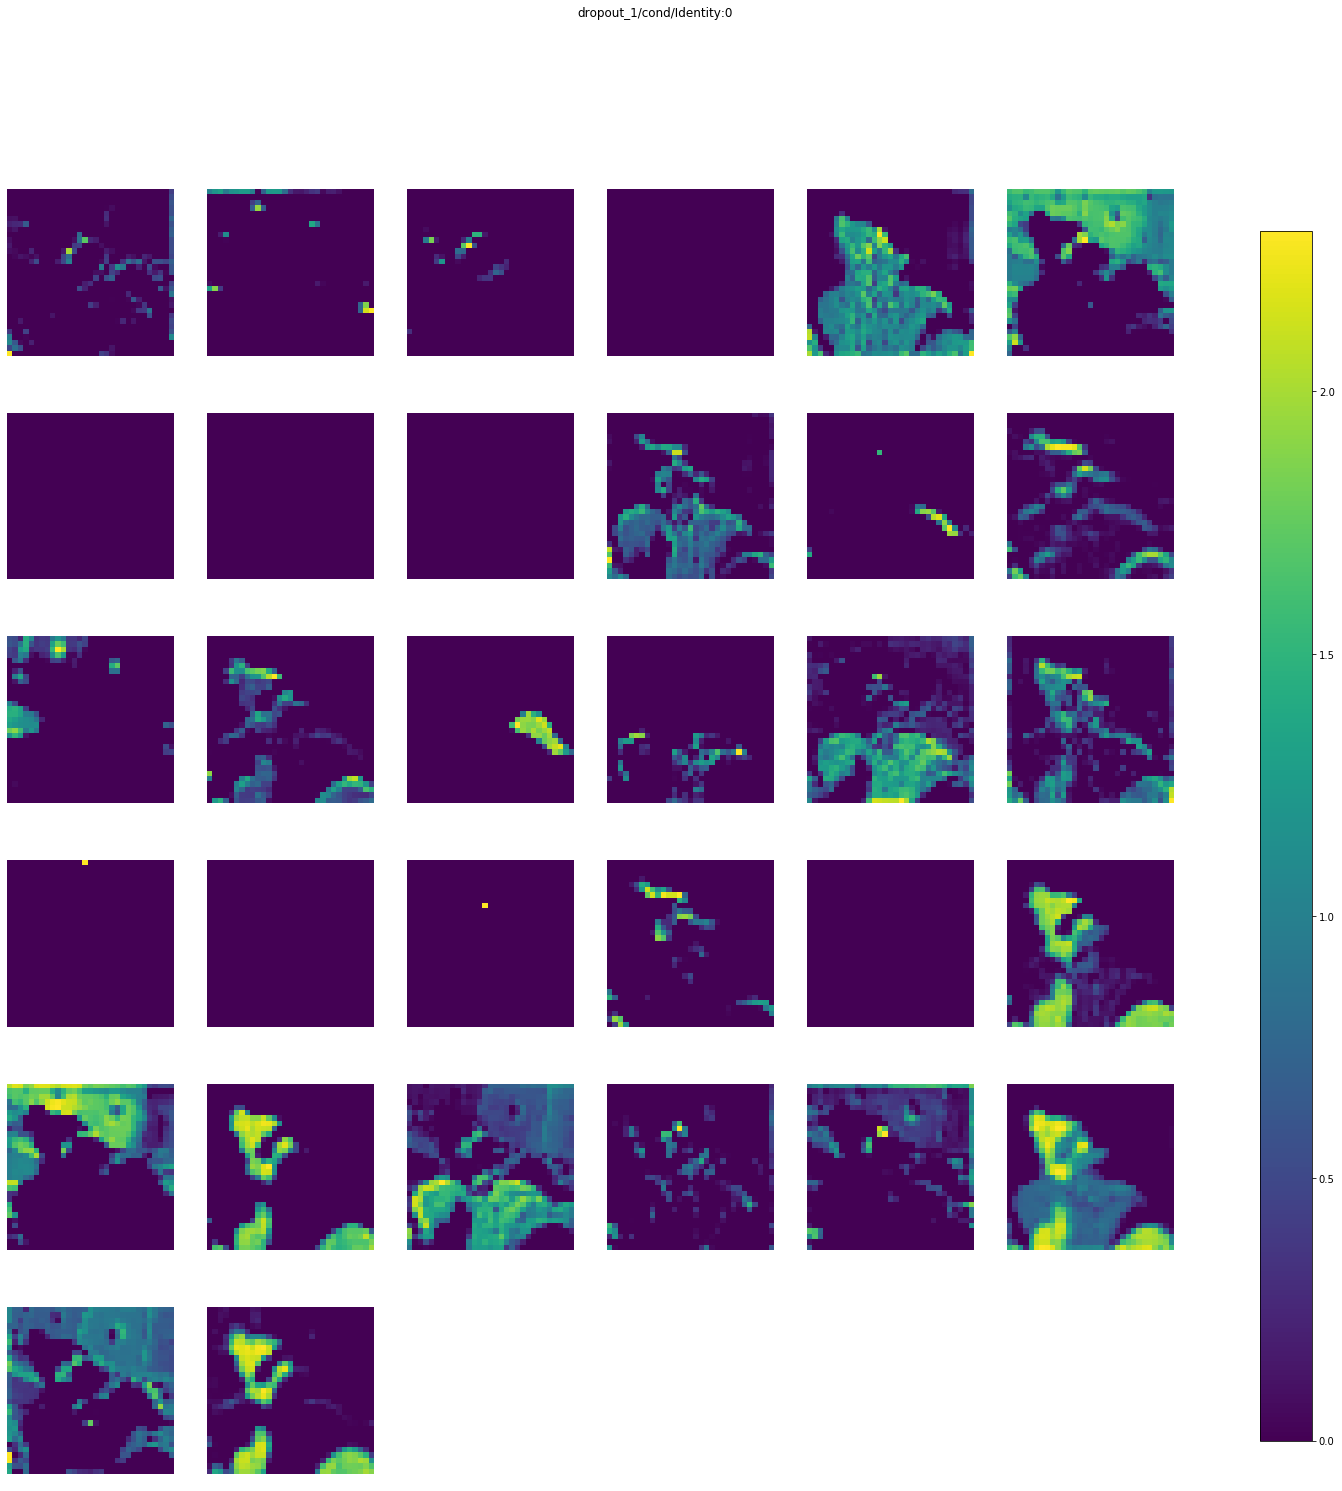

conv2d_3/BiasAdd:0 (1, 31, 31, 64) 


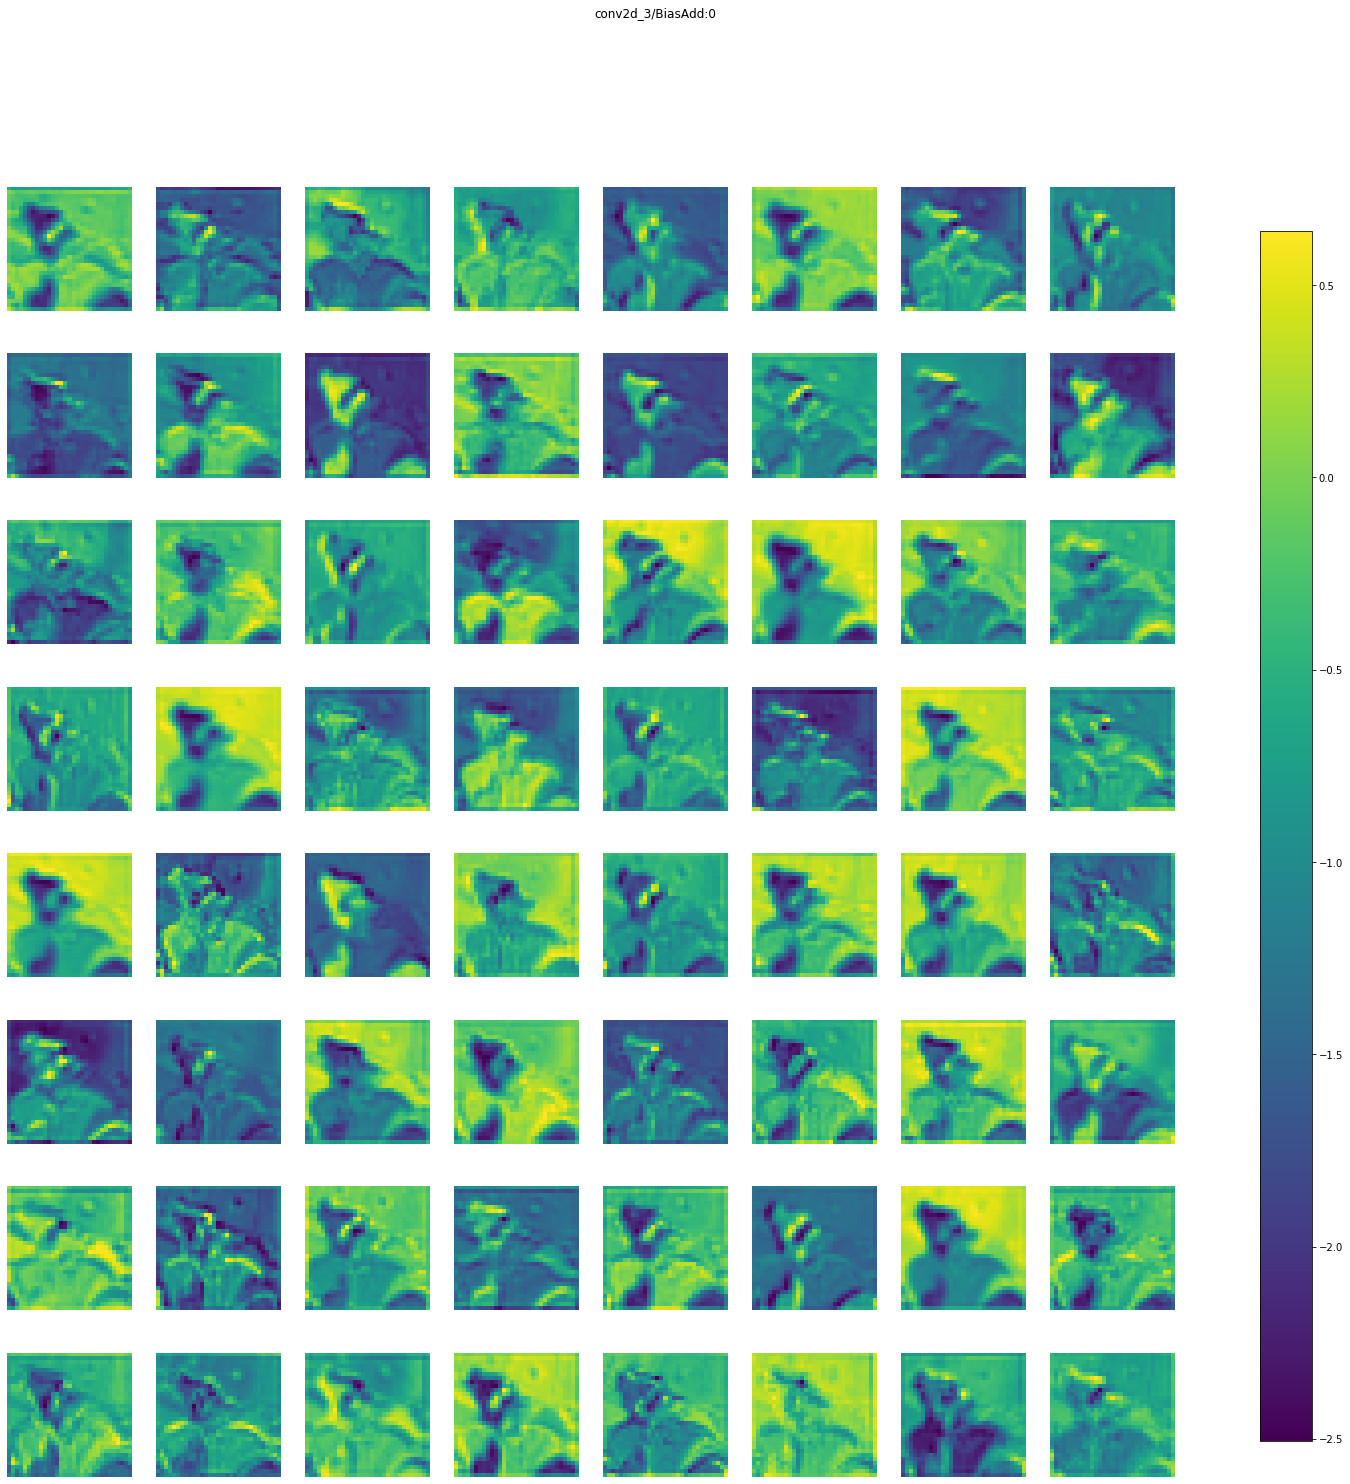

activation_3/Relu:0 (1, 31, 31, 64) 


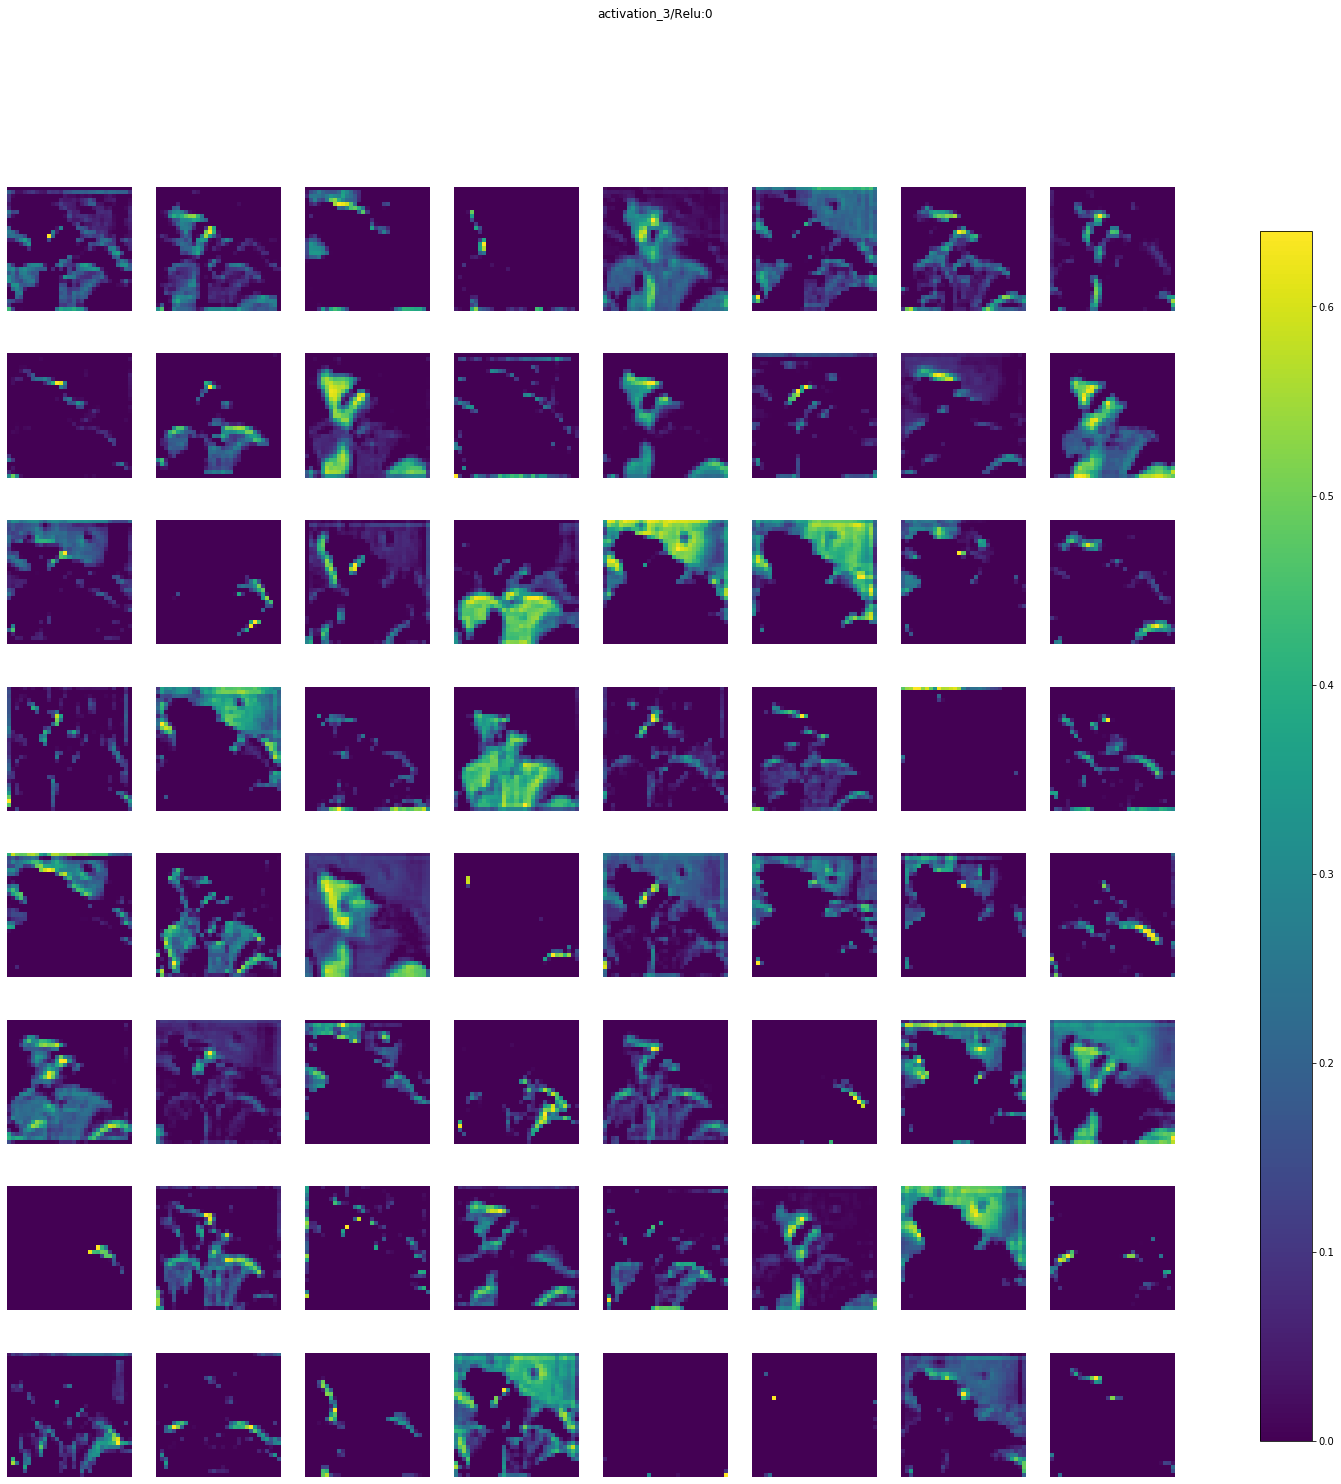

conv2d_4/BiasAdd:0 (1, 29, 29, 64) 


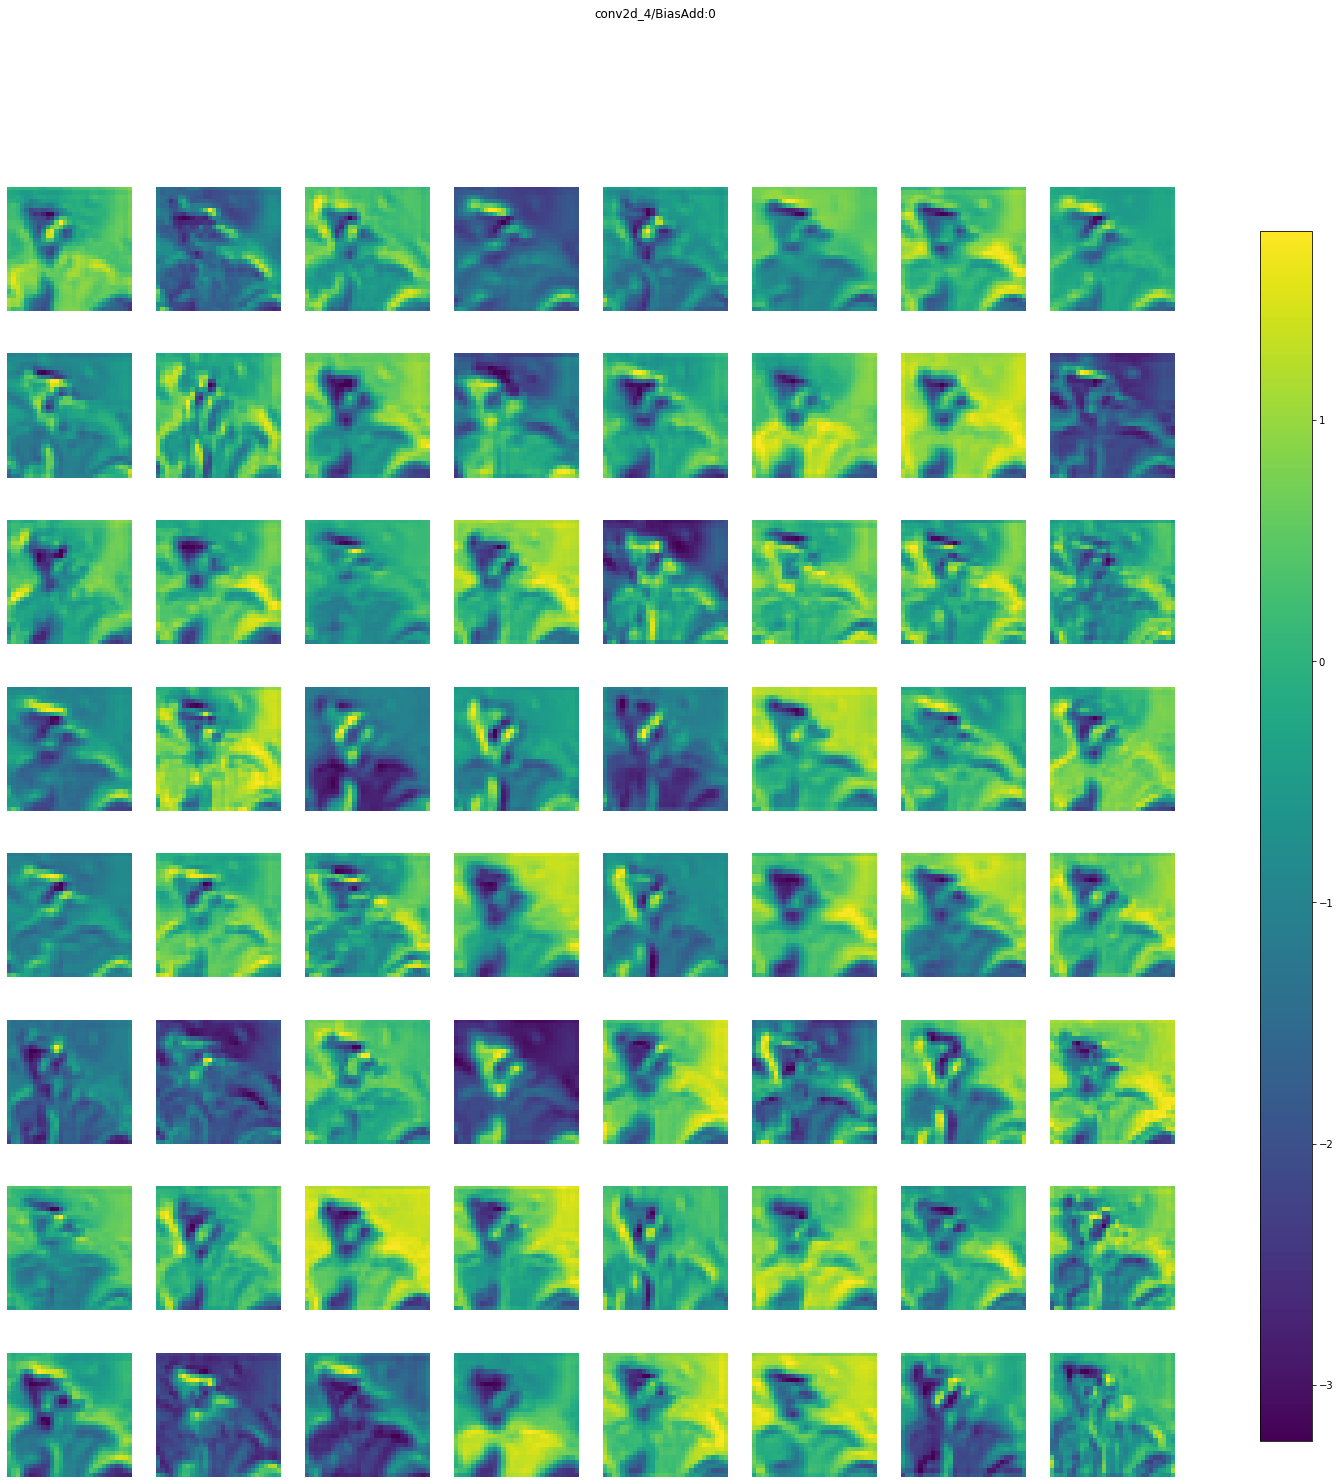

activation_4/Relu:0 (1, 29, 29, 64) 


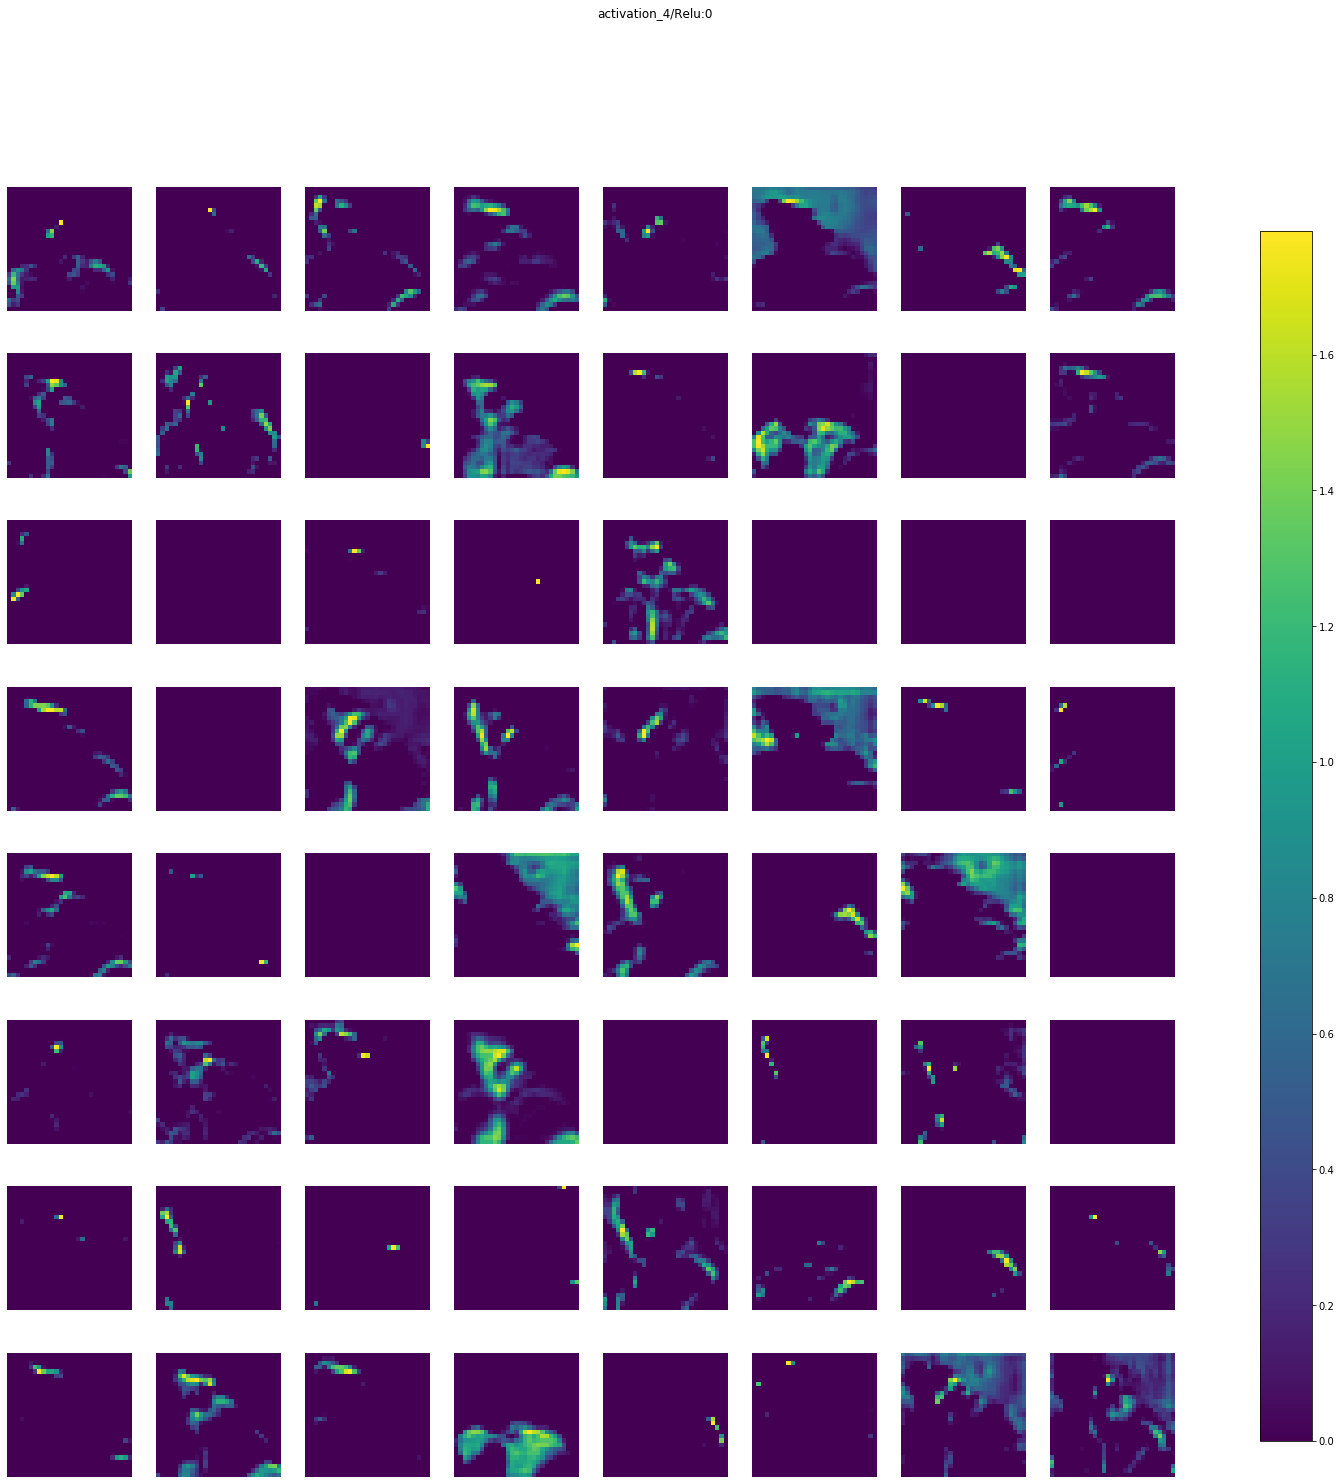

max_pooling2d_2/MaxPool:0 (1, 14, 14, 64) 


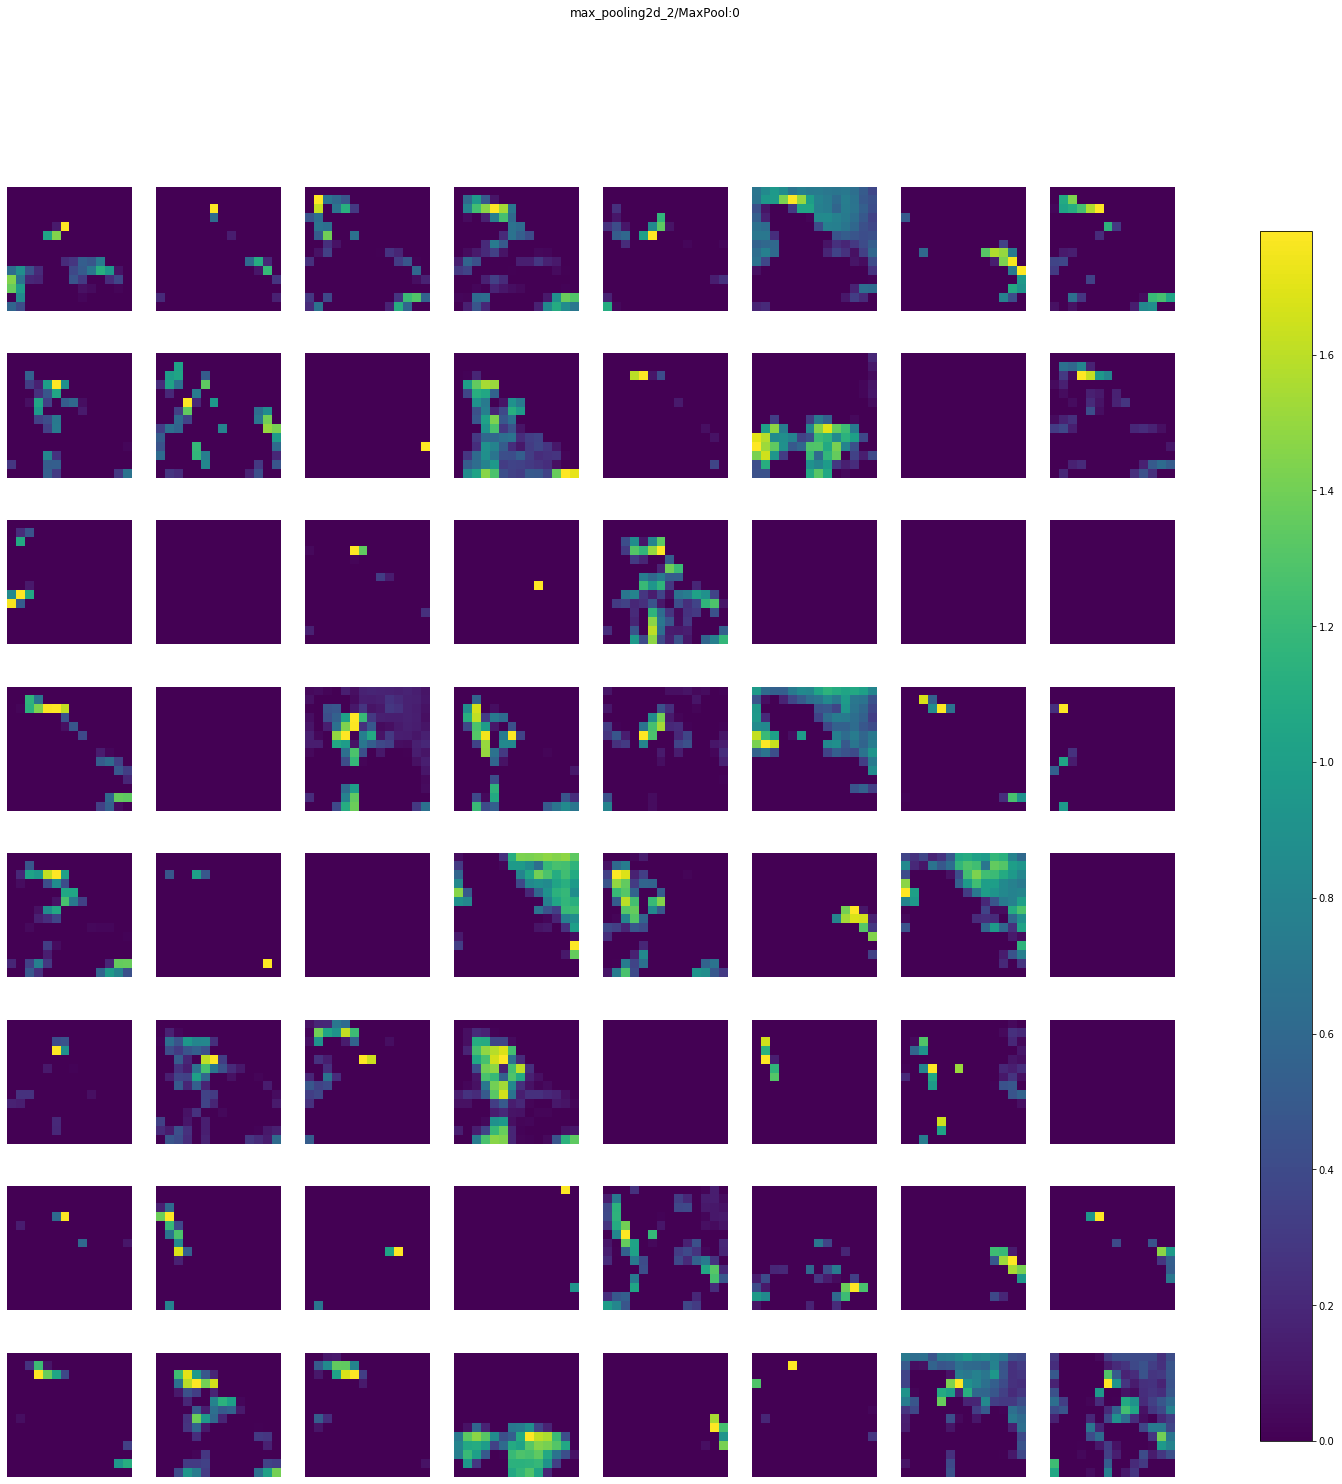

dropout_2/cond/Identity:0 (1, 14, 14, 64) 


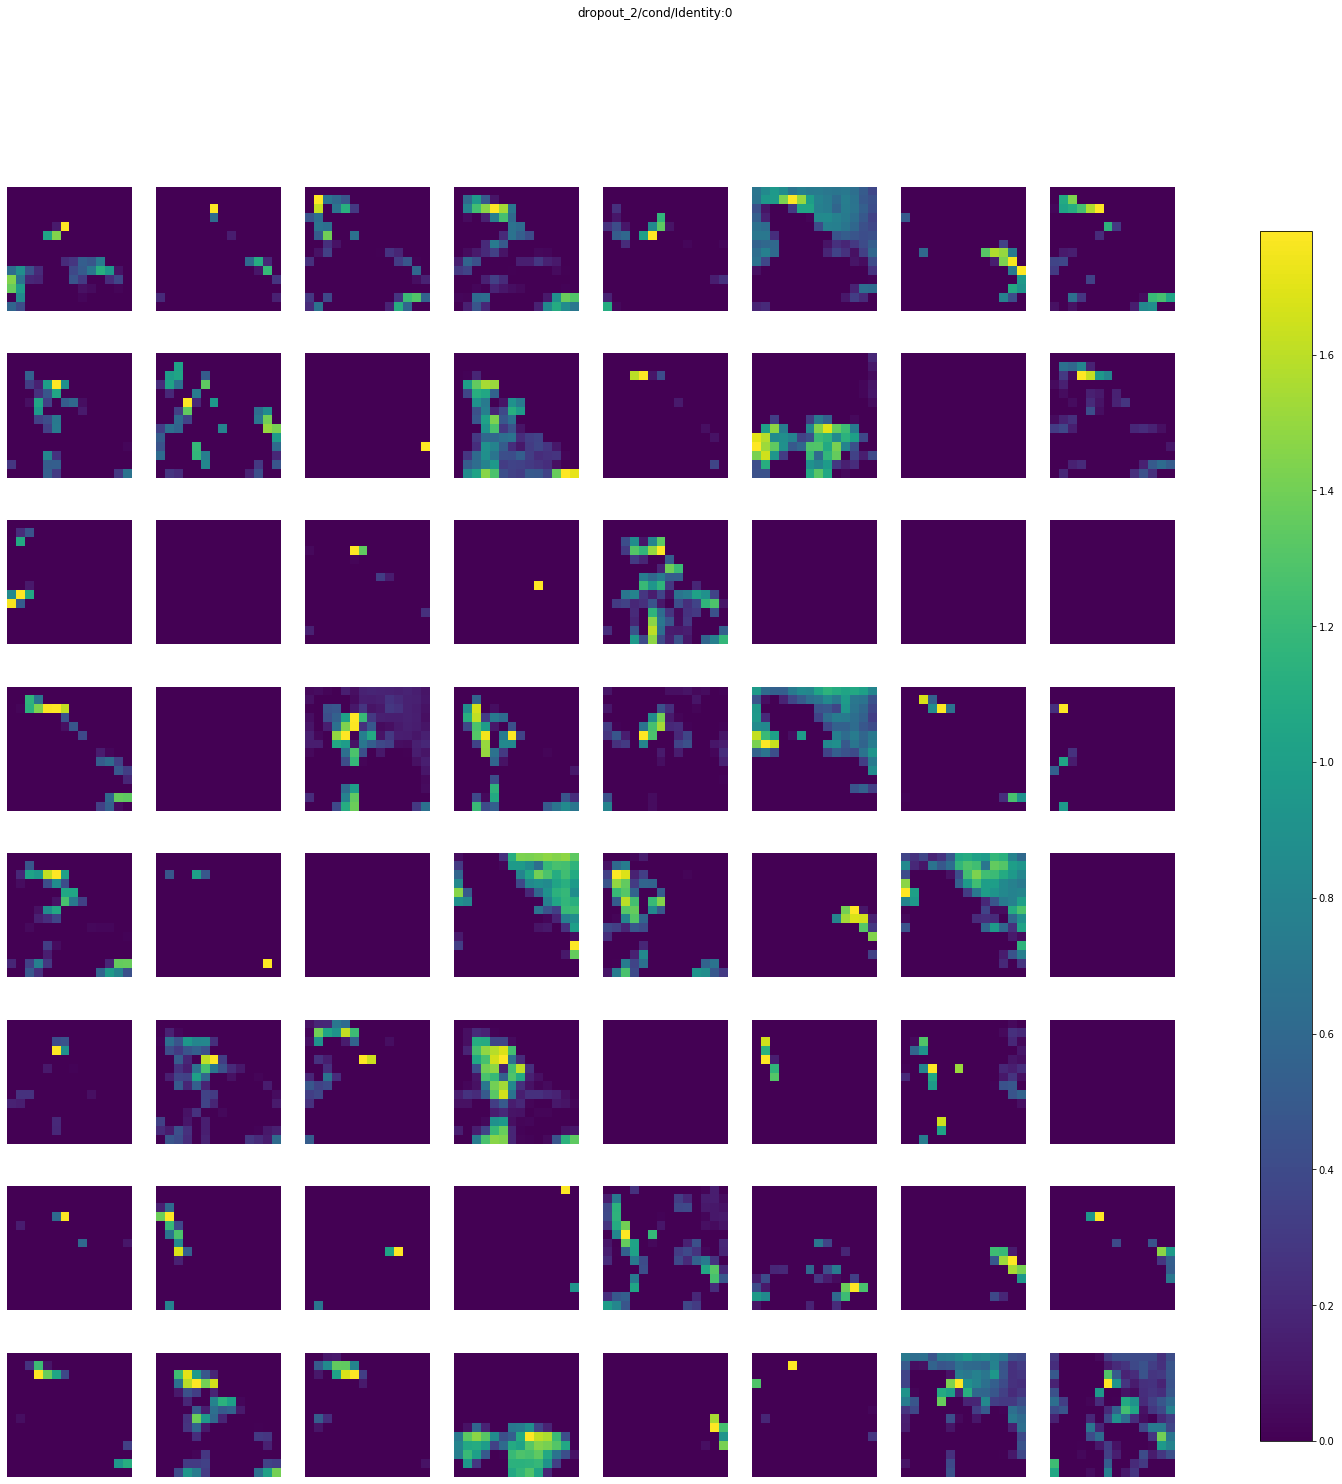

conv2d_5/BiasAdd:0 (1, 14, 14, 256) 


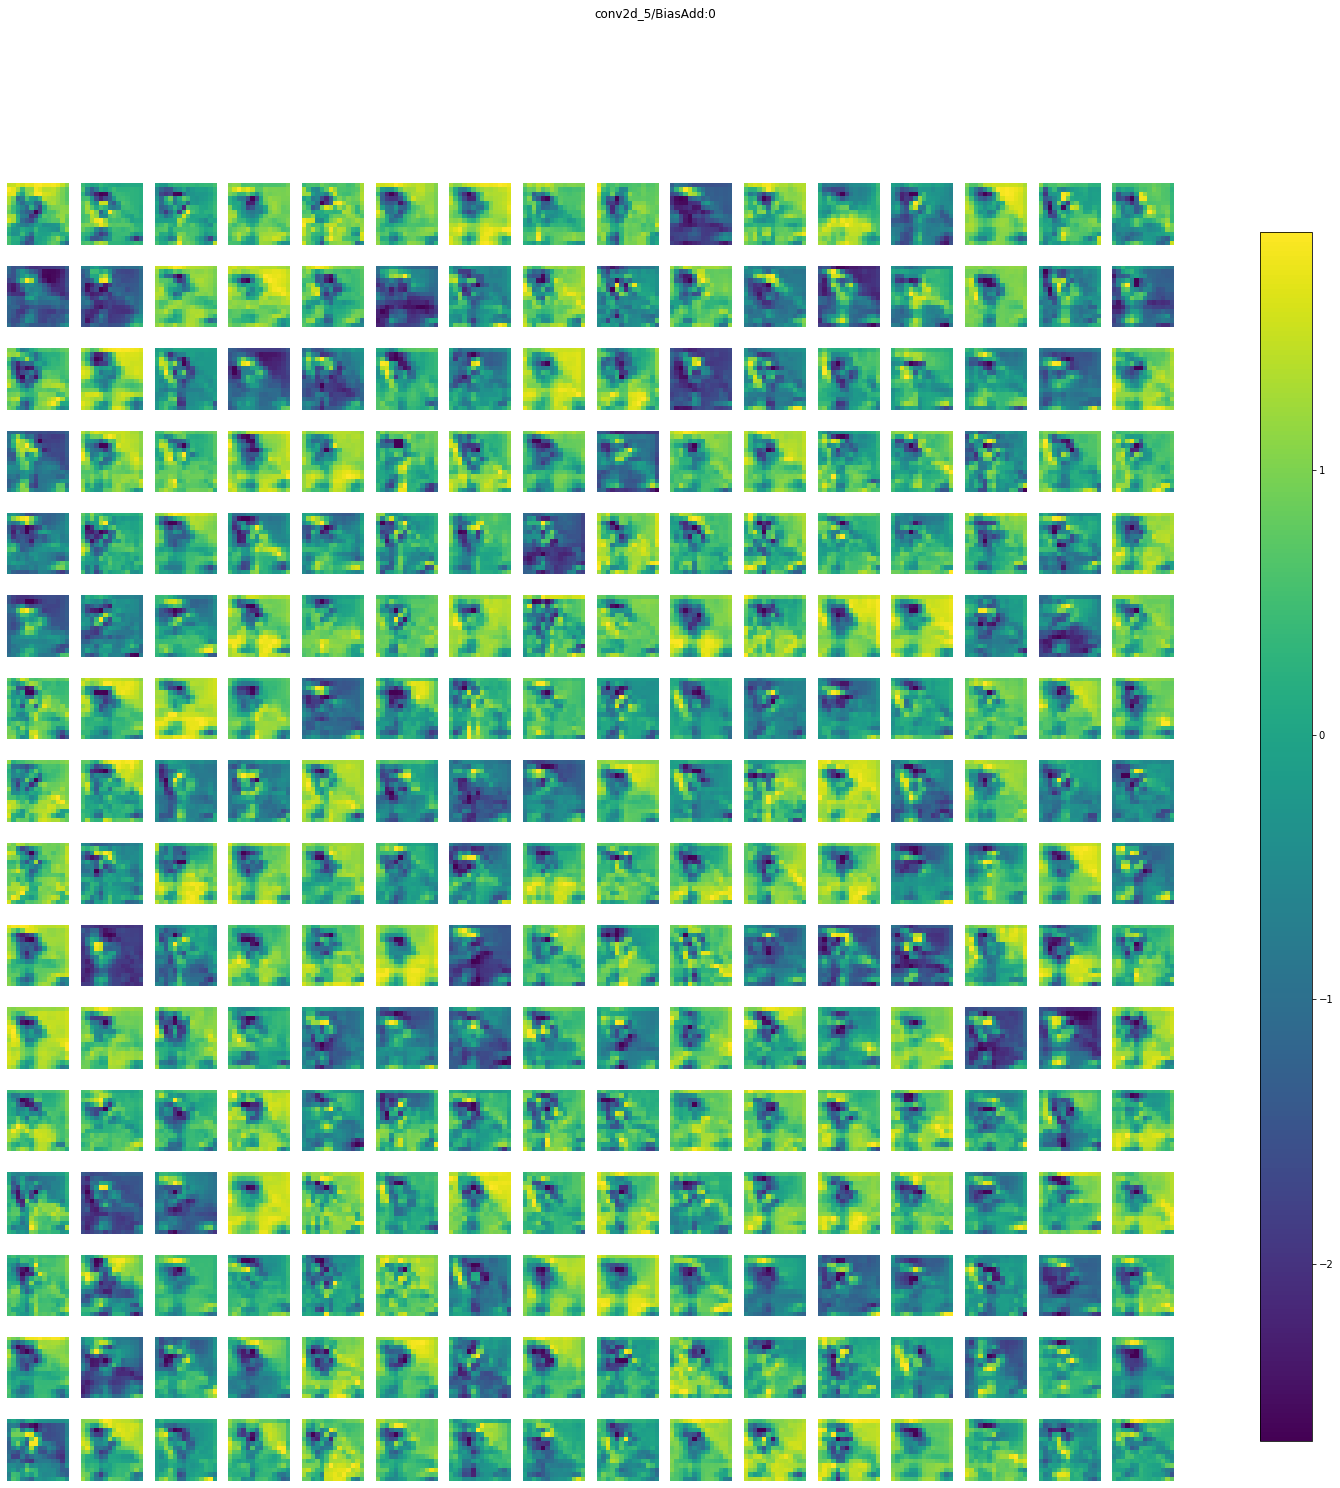

activation_5/Relu:0 (1, 14, 14, 256) 


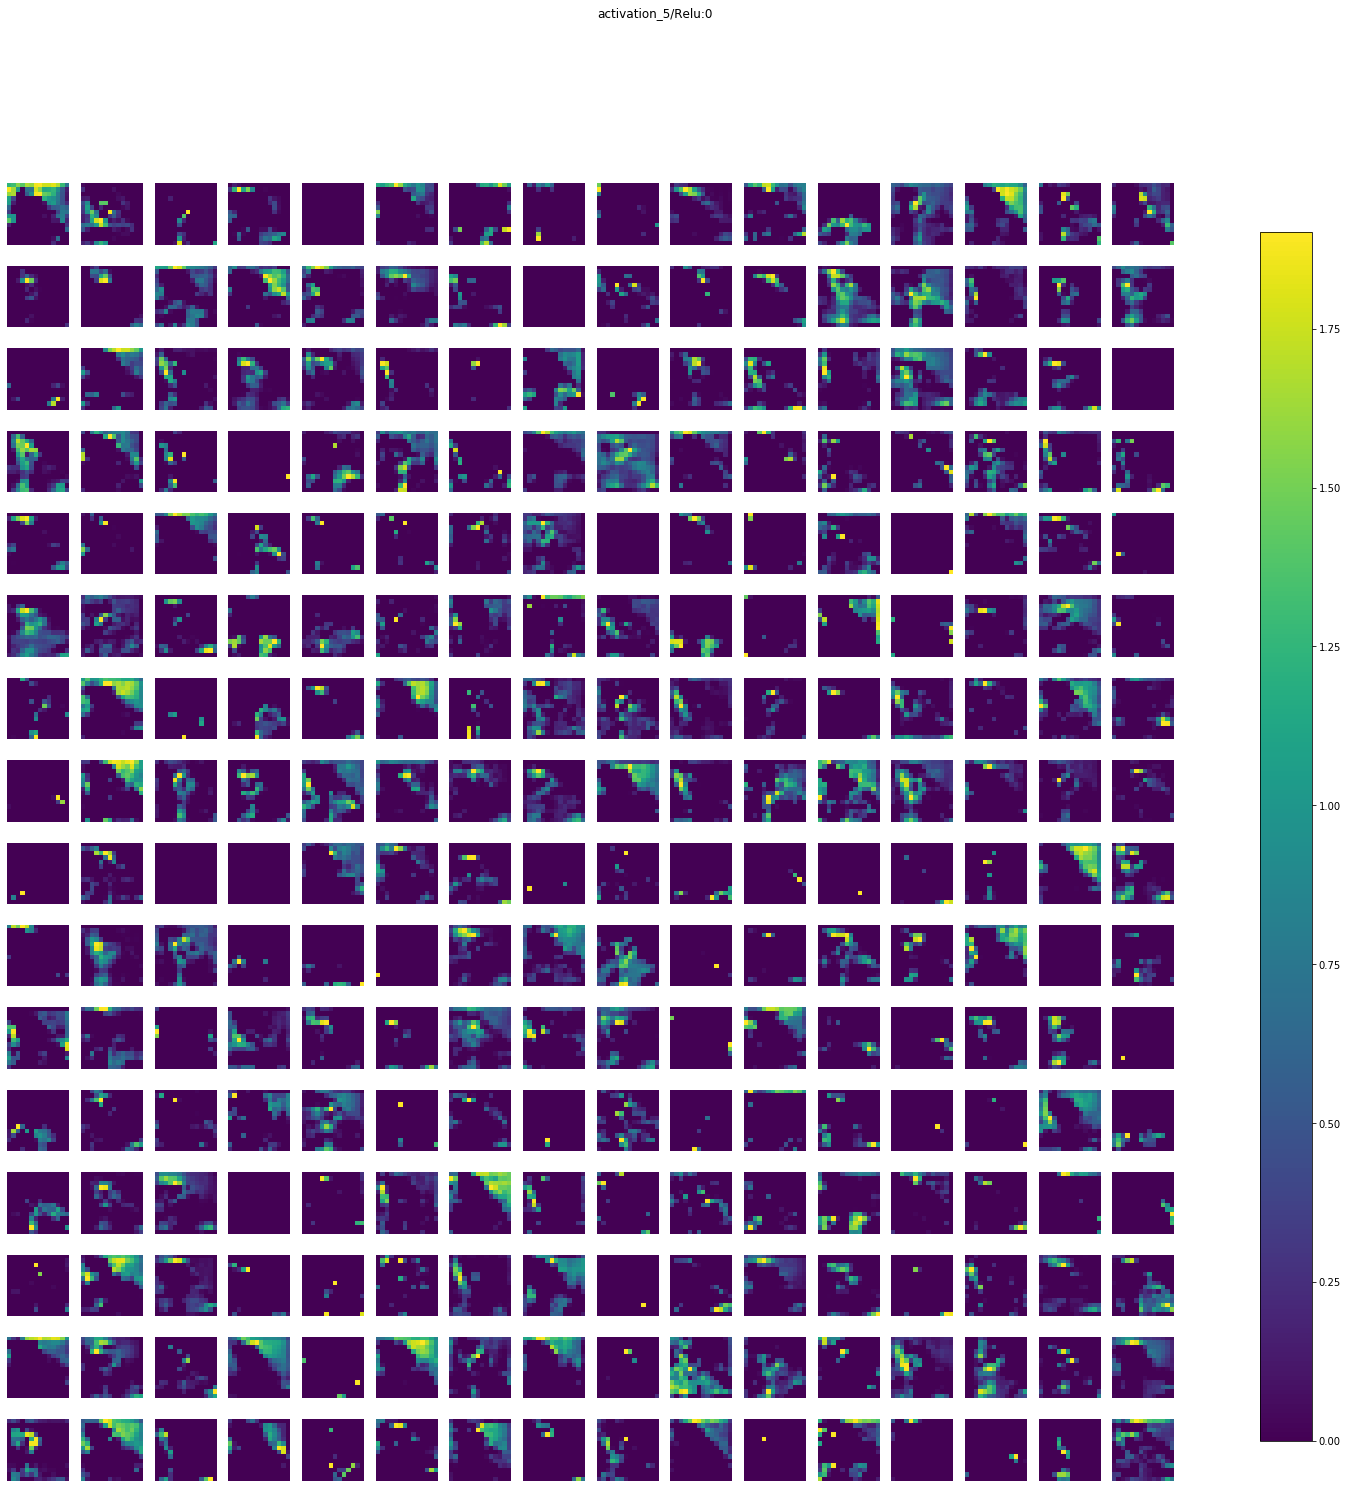

conv2d_6/BiasAdd:0 (1, 12, 12, 256) 


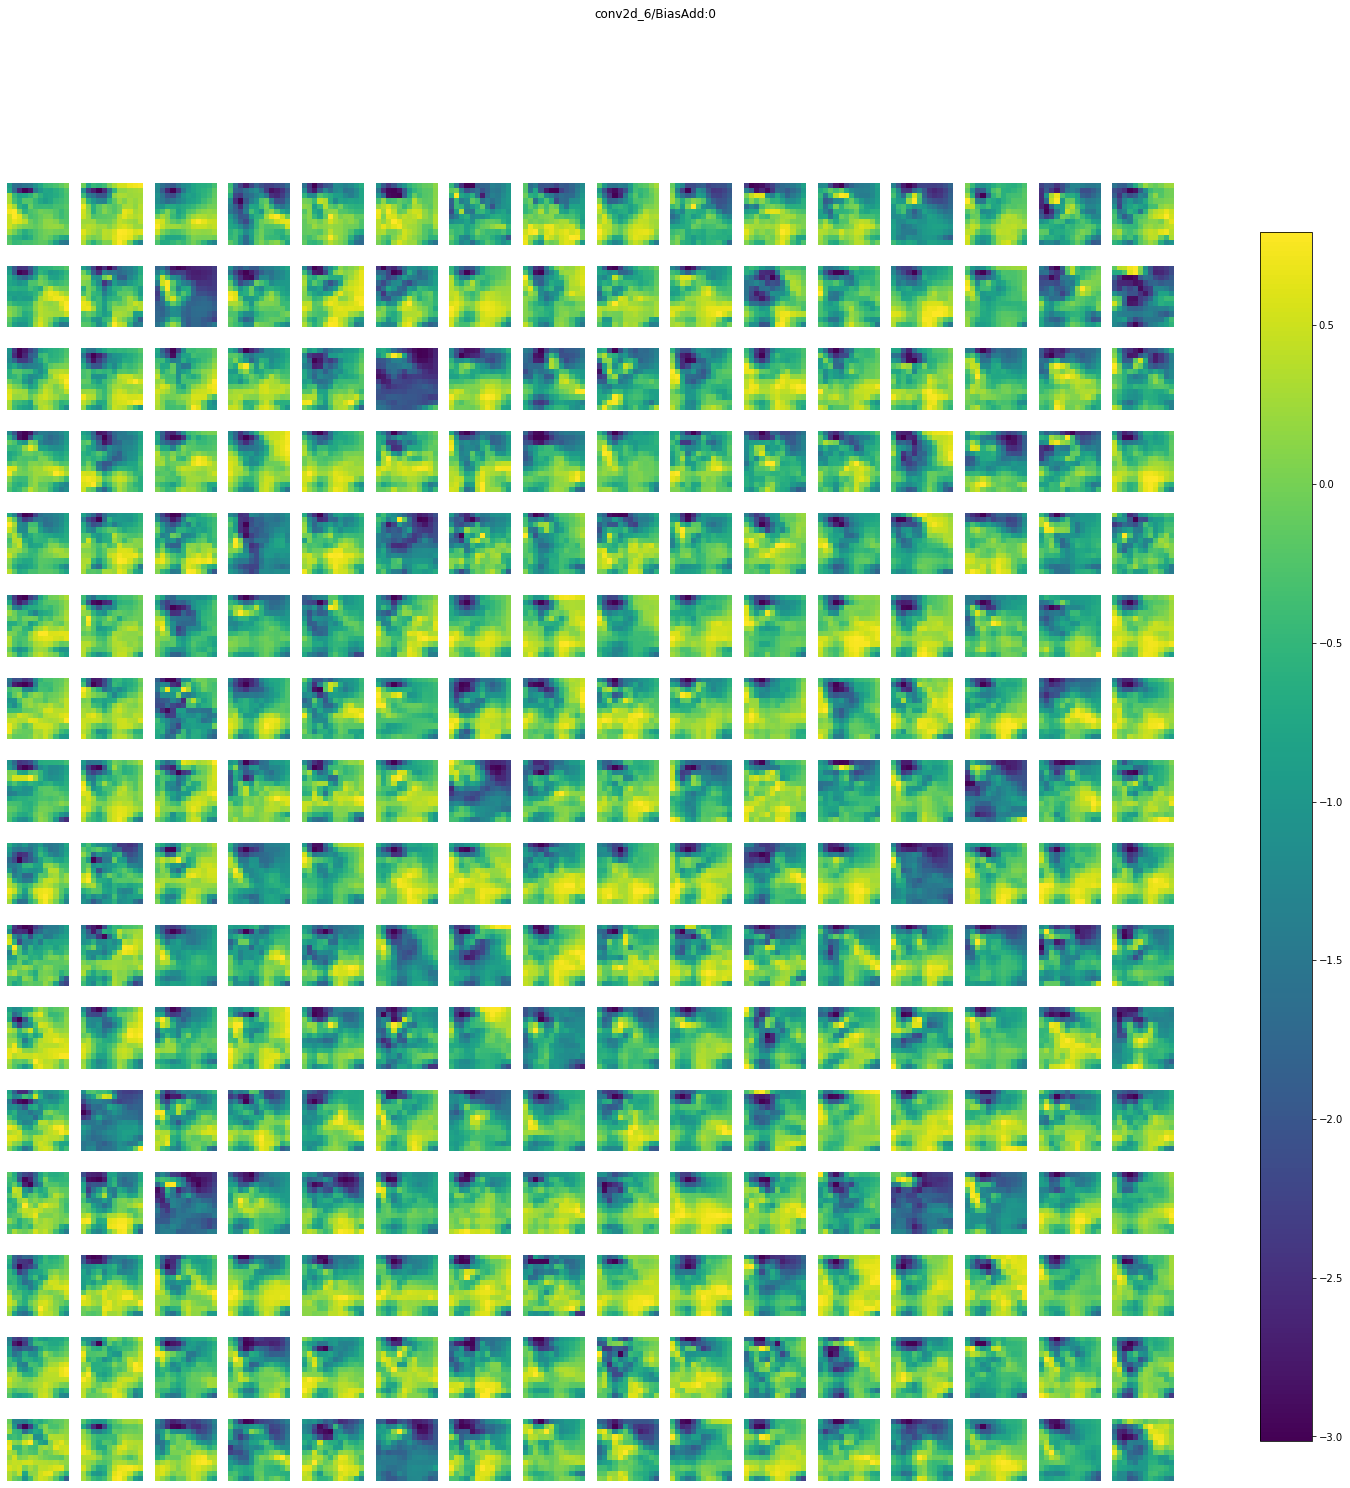

activation_6/Relu:0 (1, 12, 12, 256) 


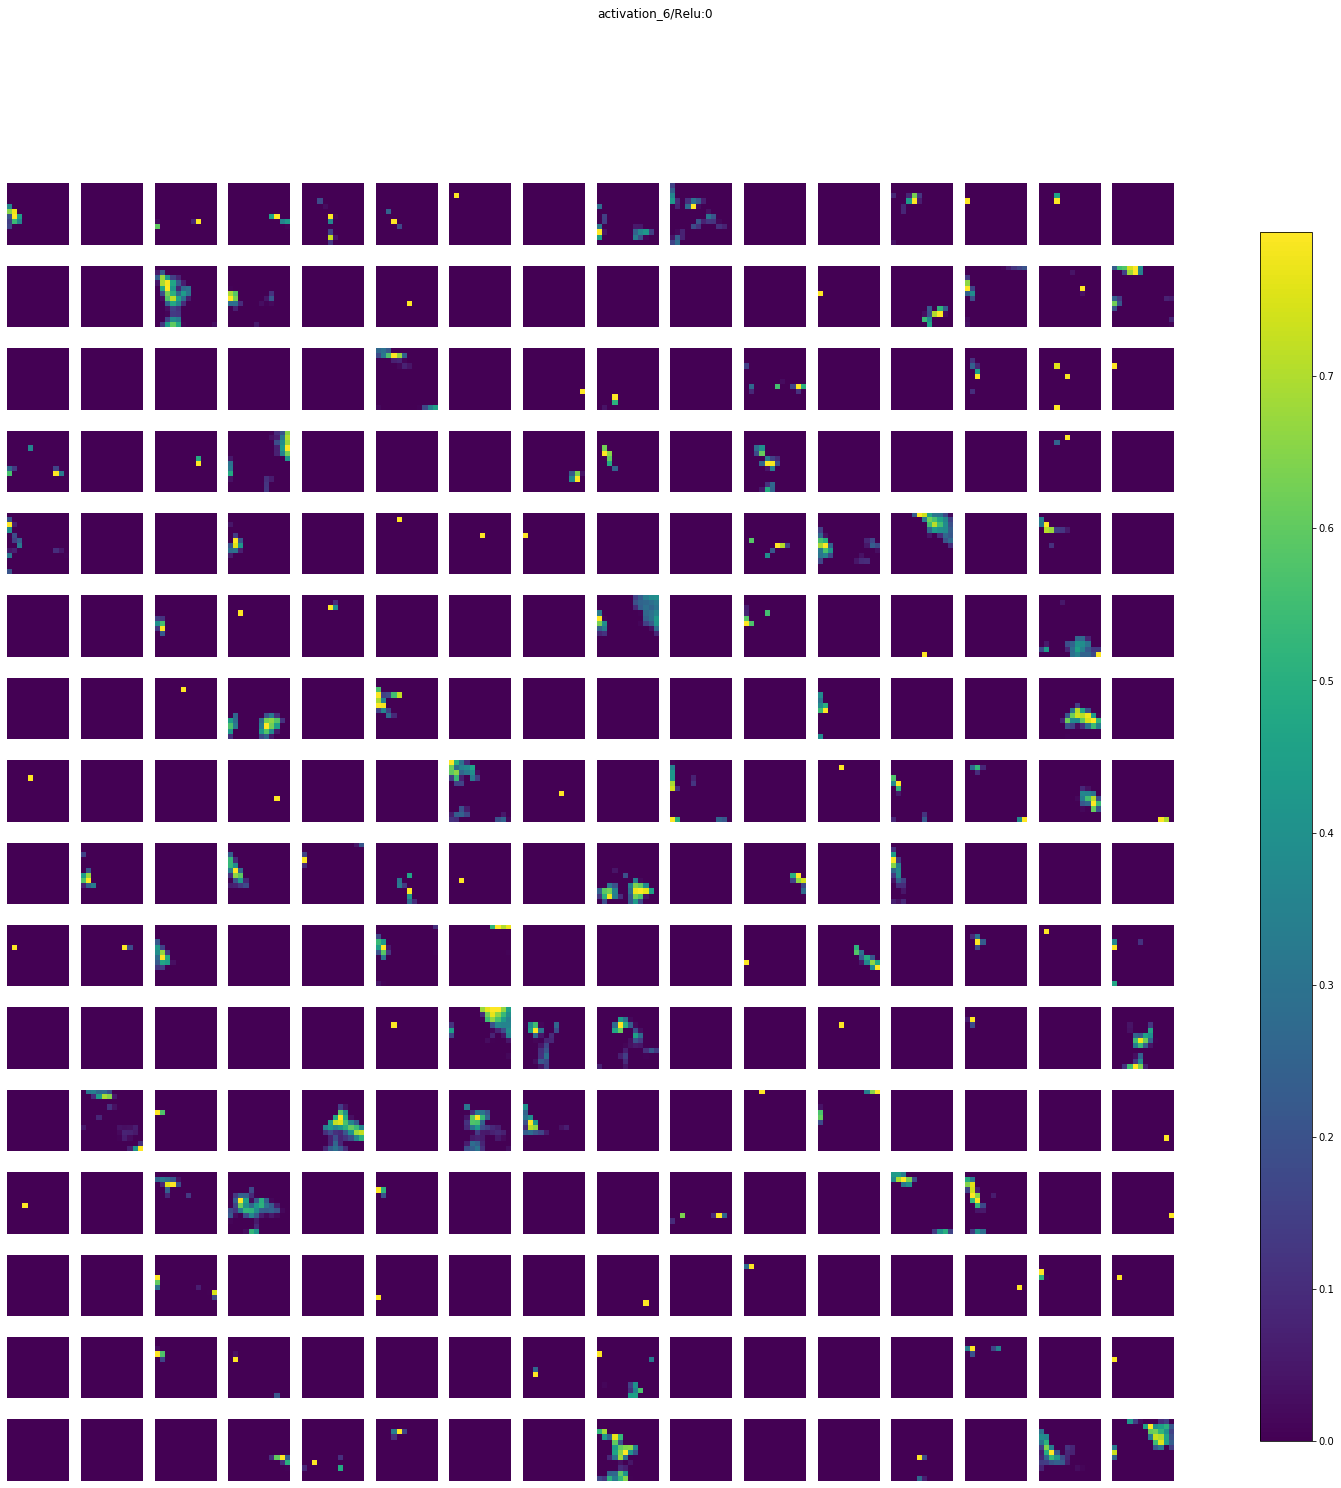

max_pooling2d_3/MaxPool:0 (1, 6, 6, 256) 


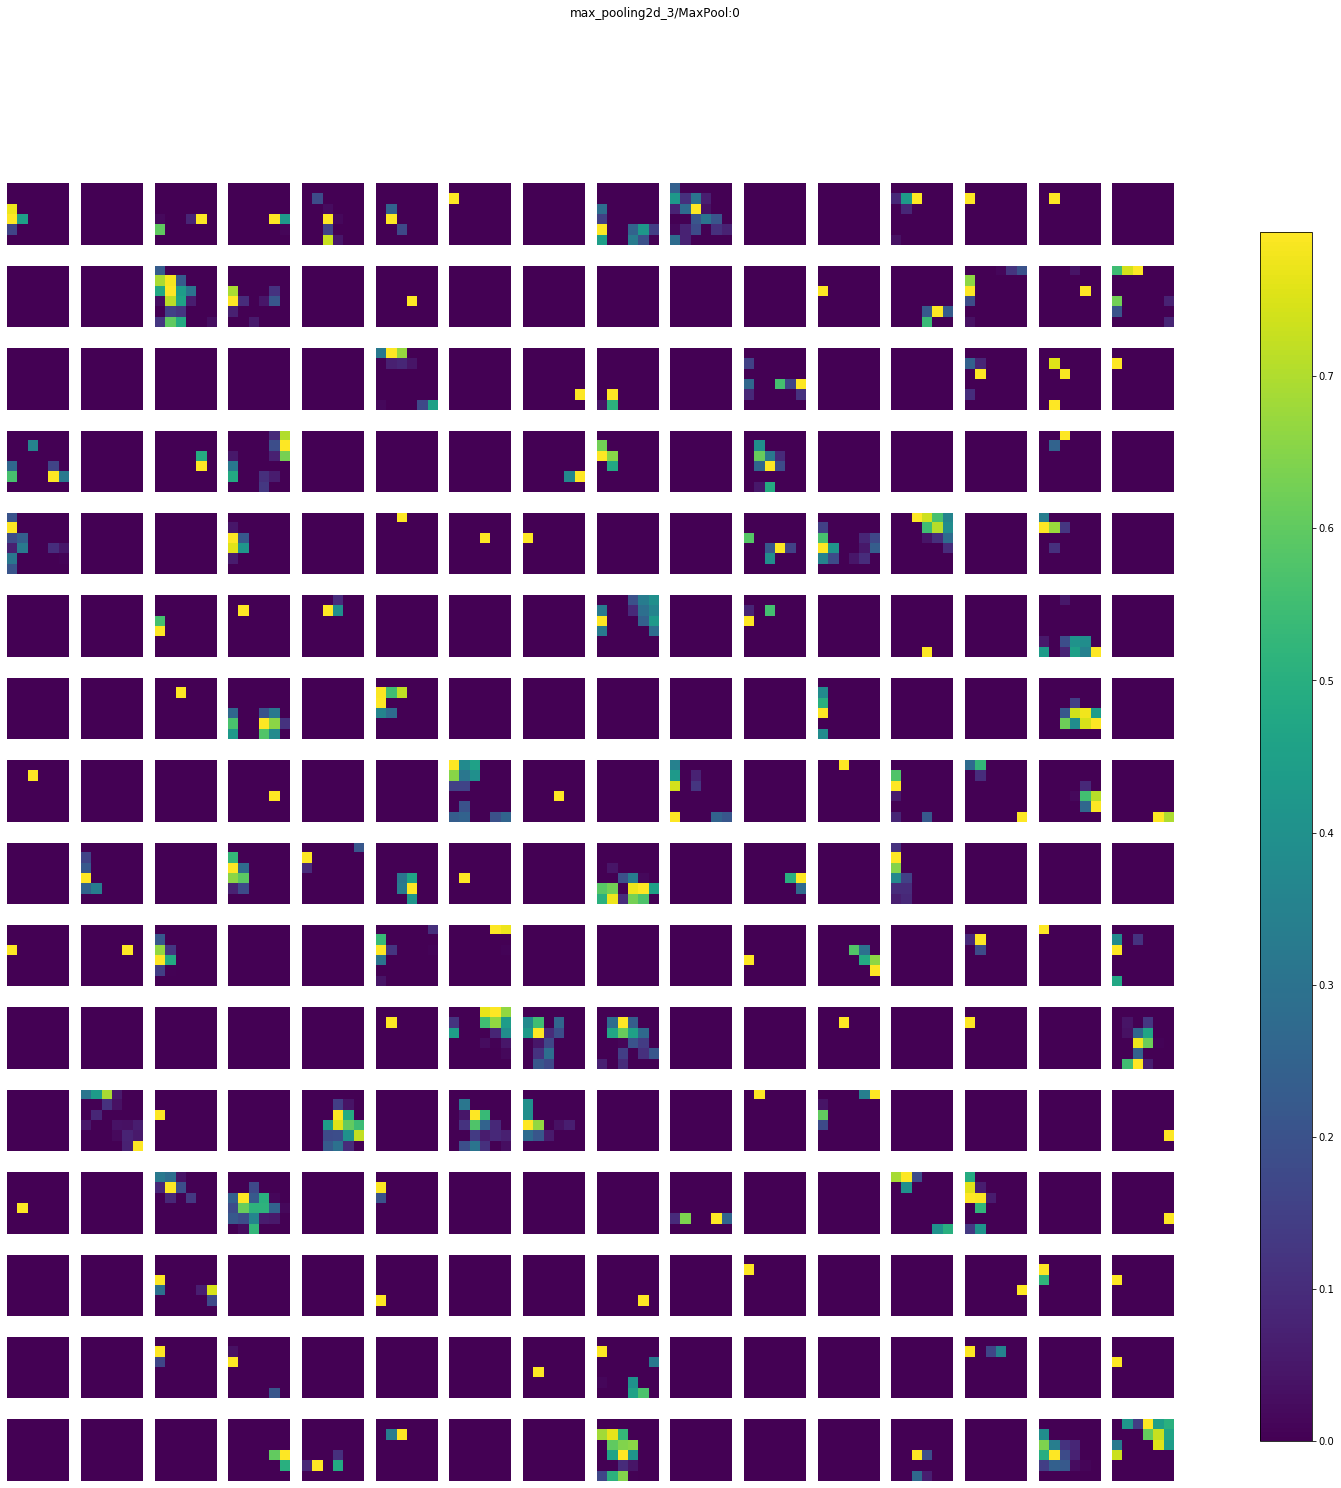

dropout_3/cond/Identity:0 (1, 6, 6, 256) 


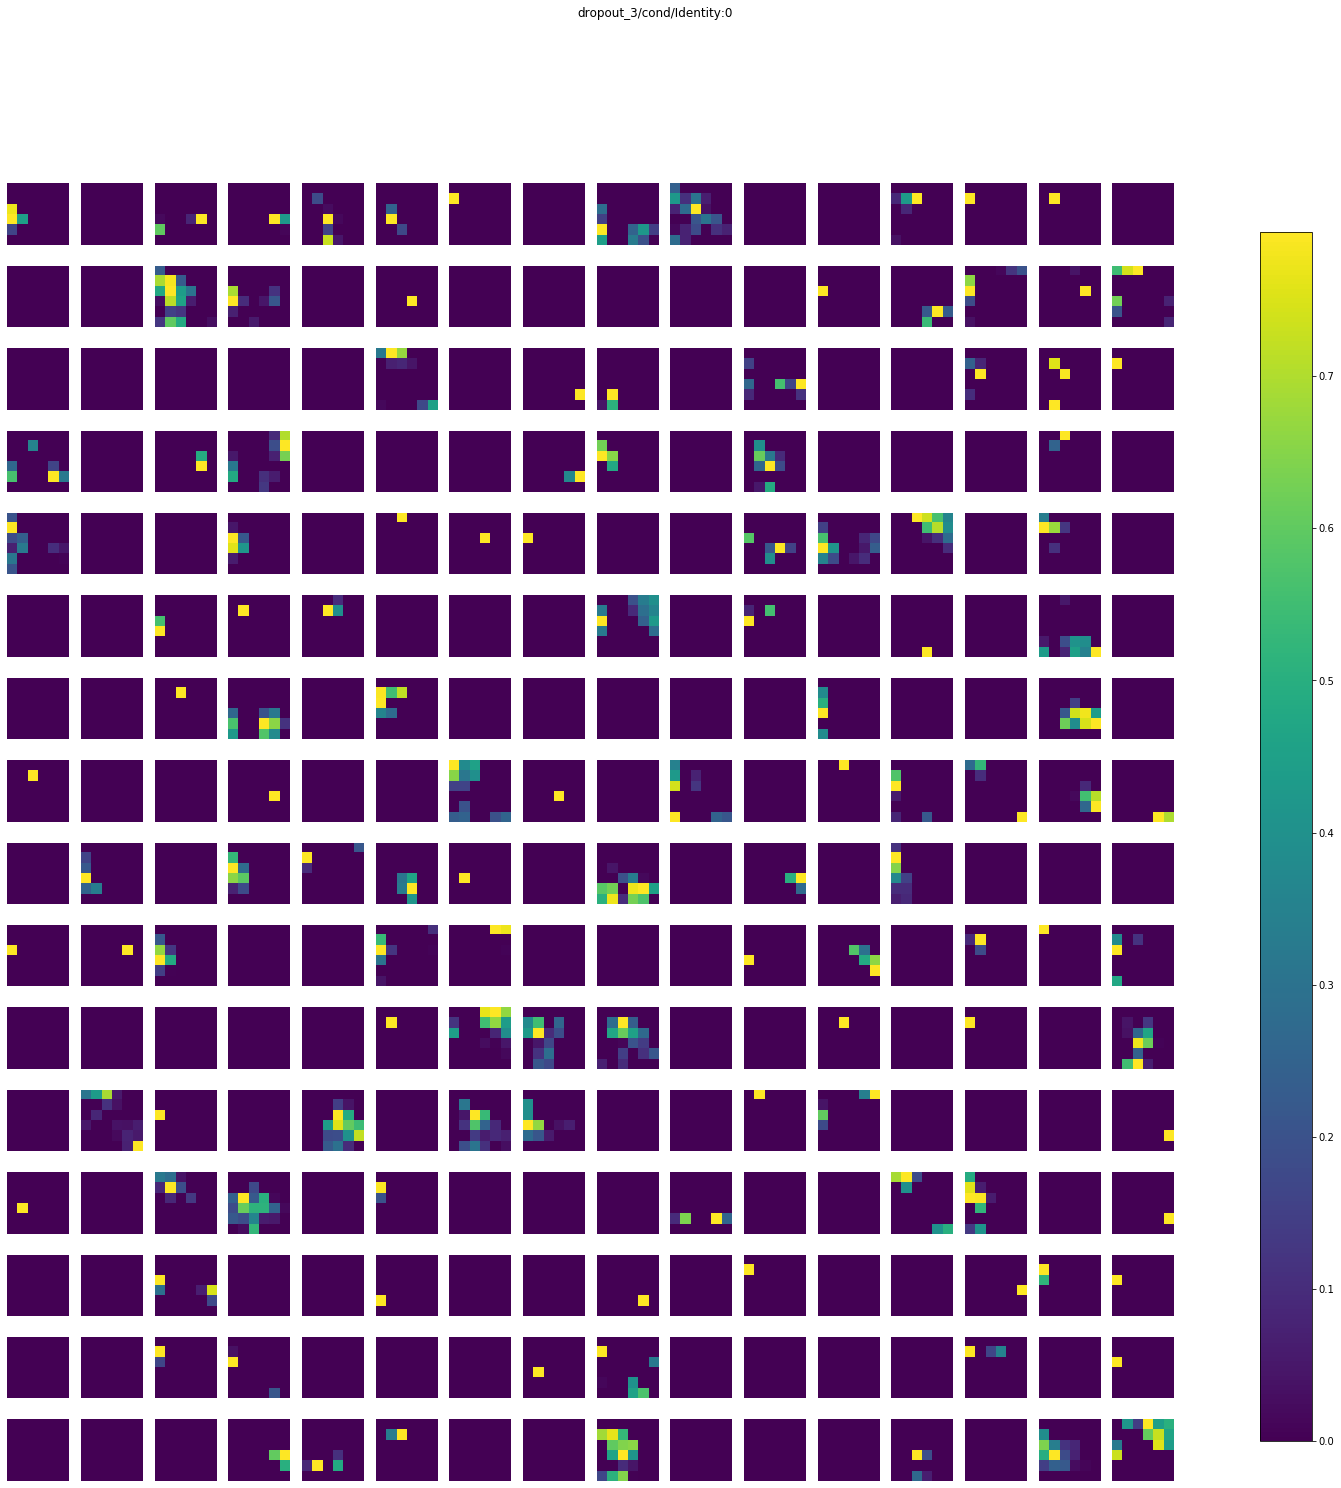

flatten_1/Reshape:0 (1, 9216) 


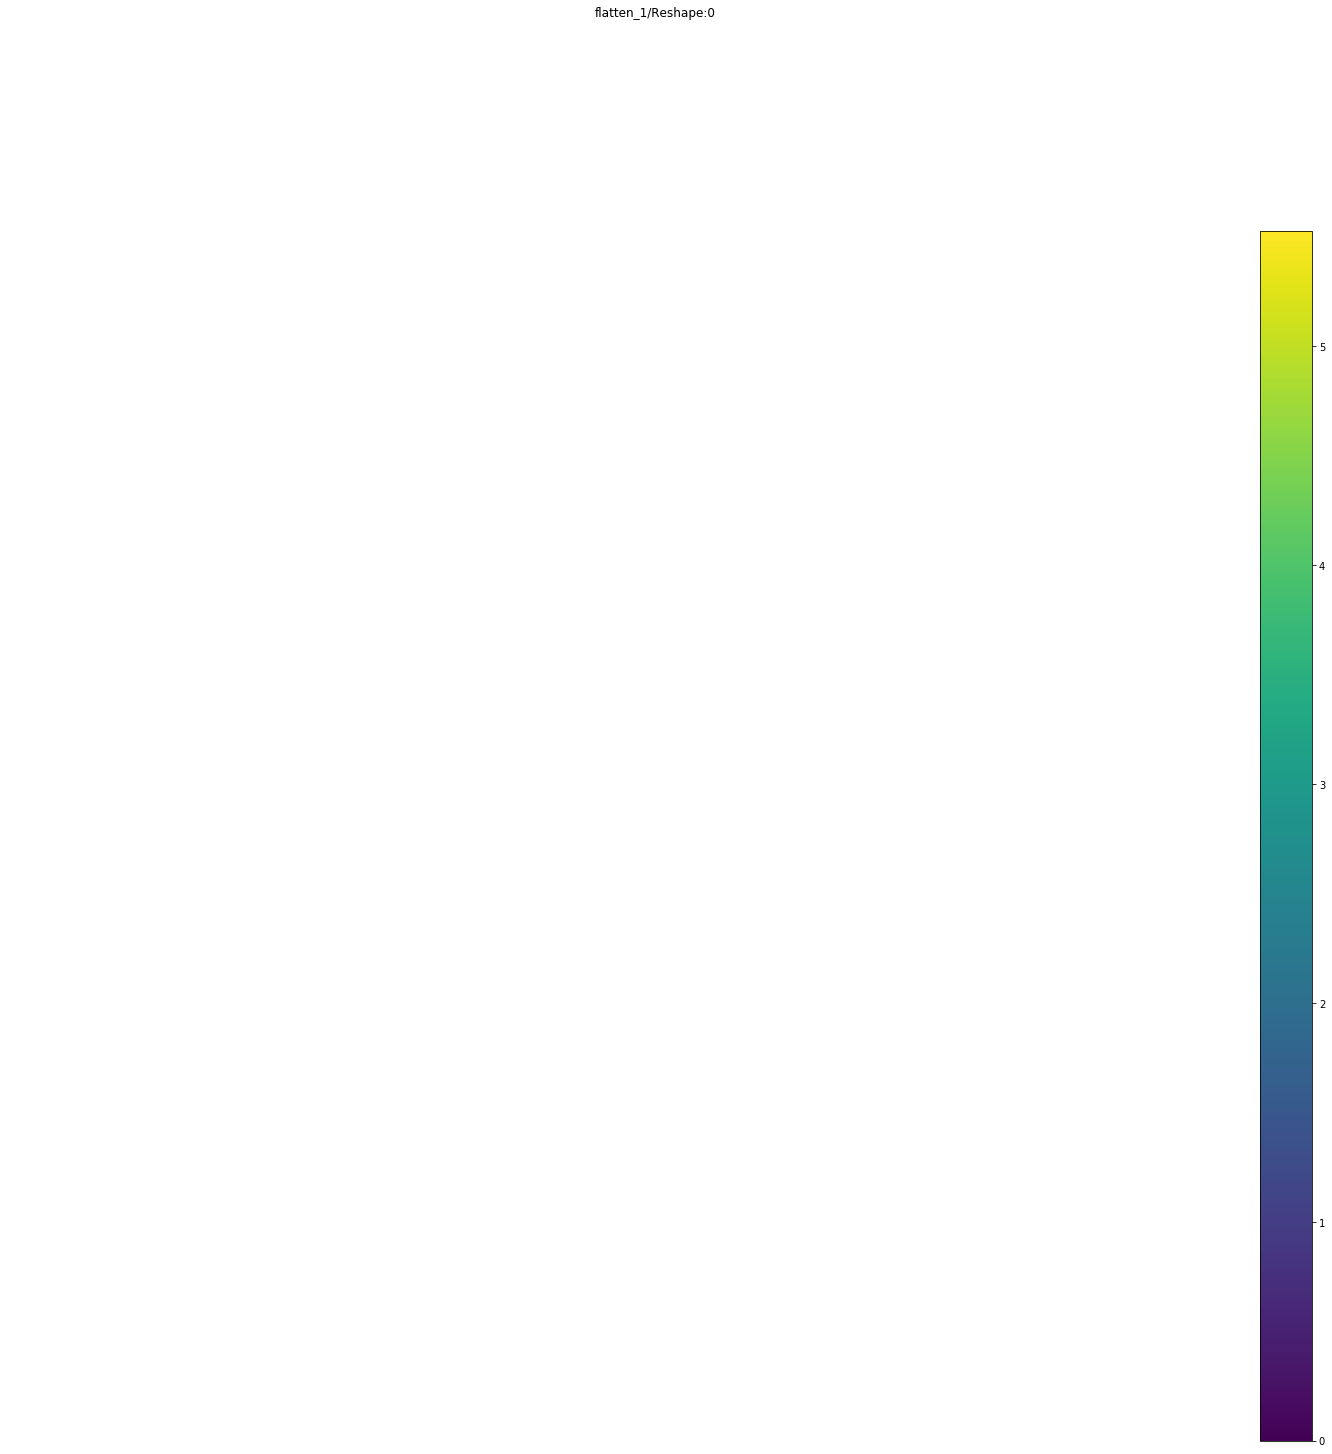

dense_1/BiasAdd:0 (1, 1024) 


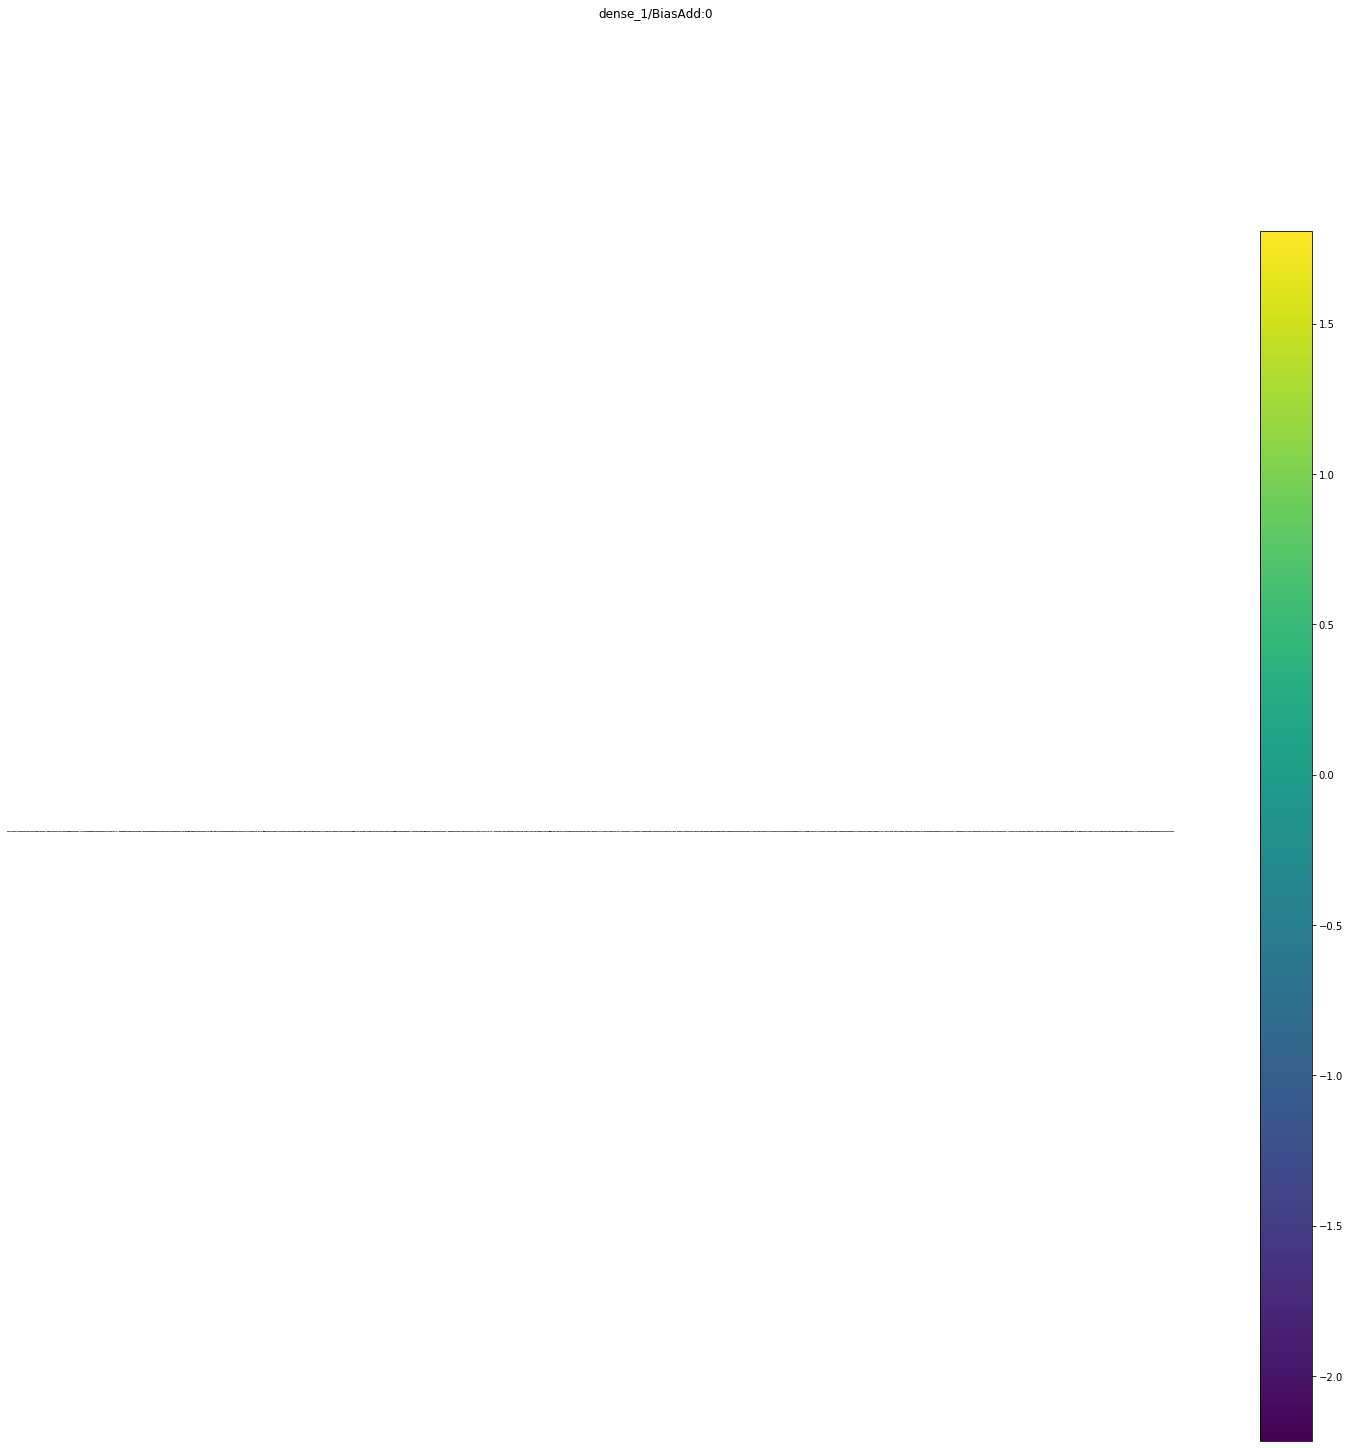

activation_7/Relu:0 (1, 1024) 


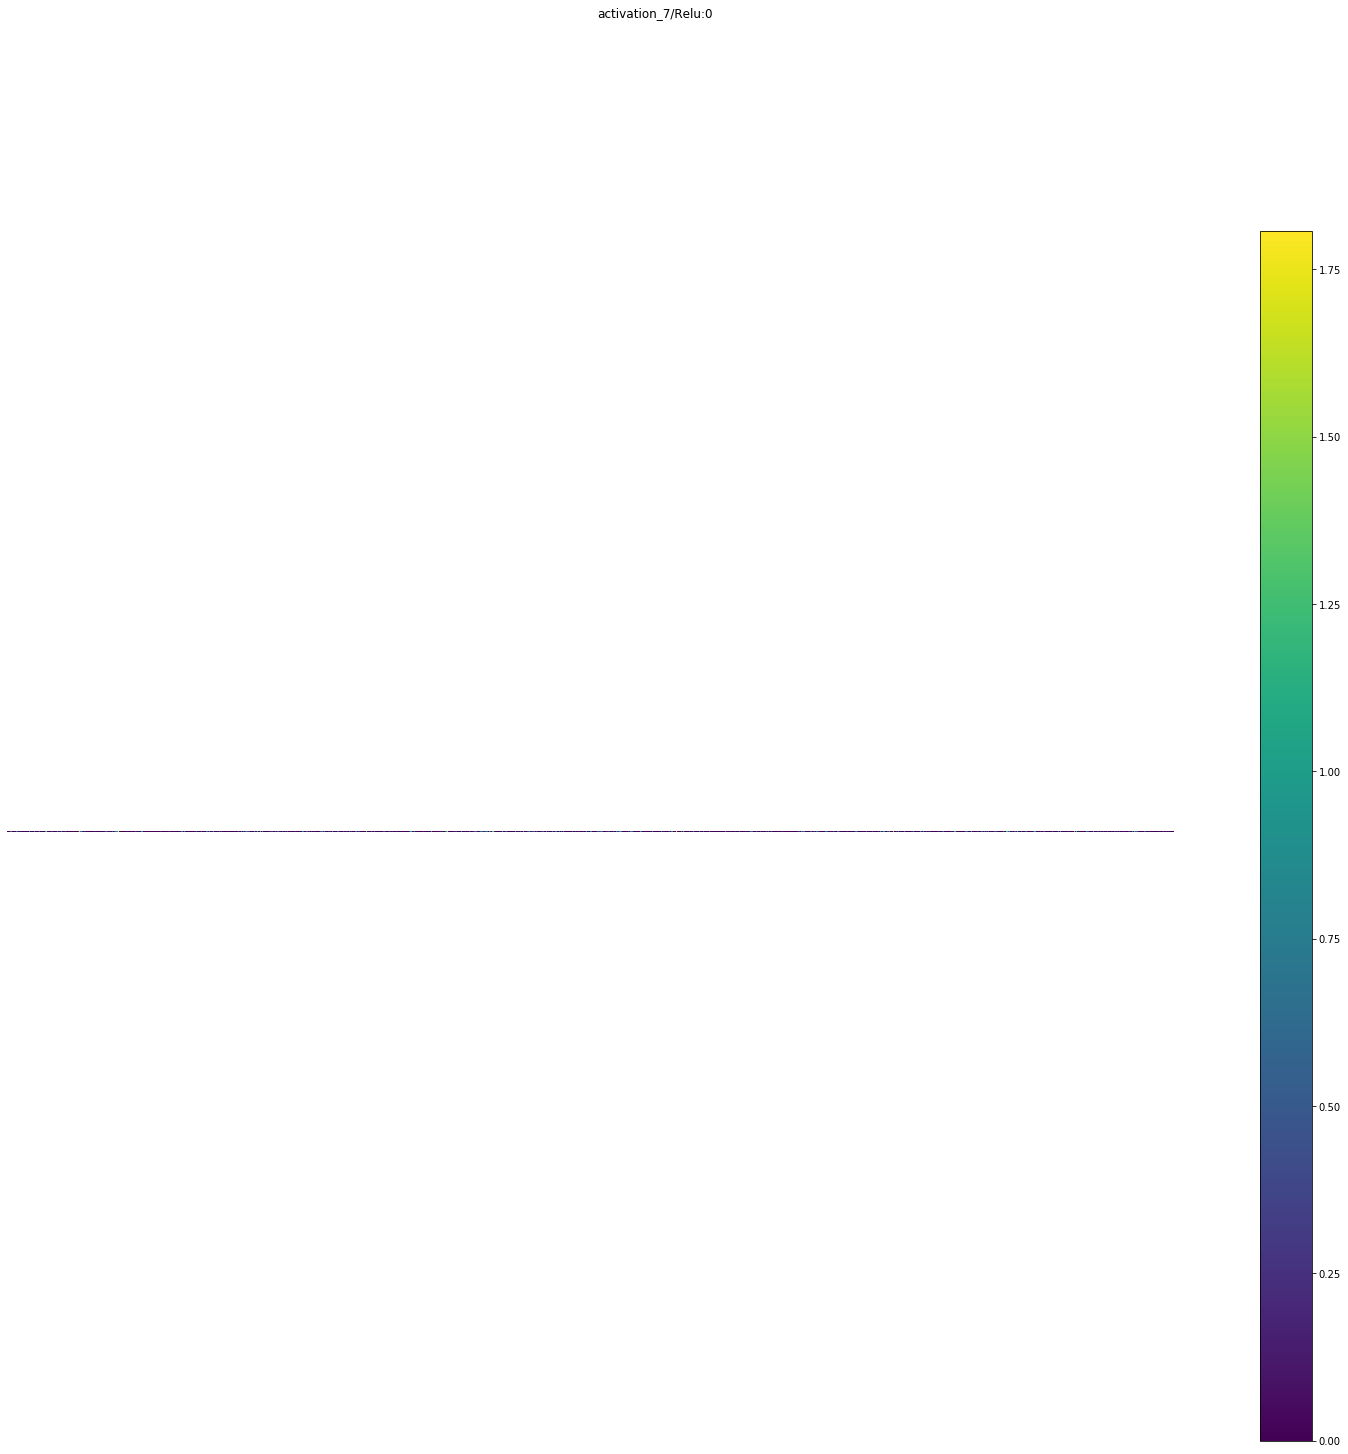

dropout_4/cond/Identity:0 (1, 1024) 


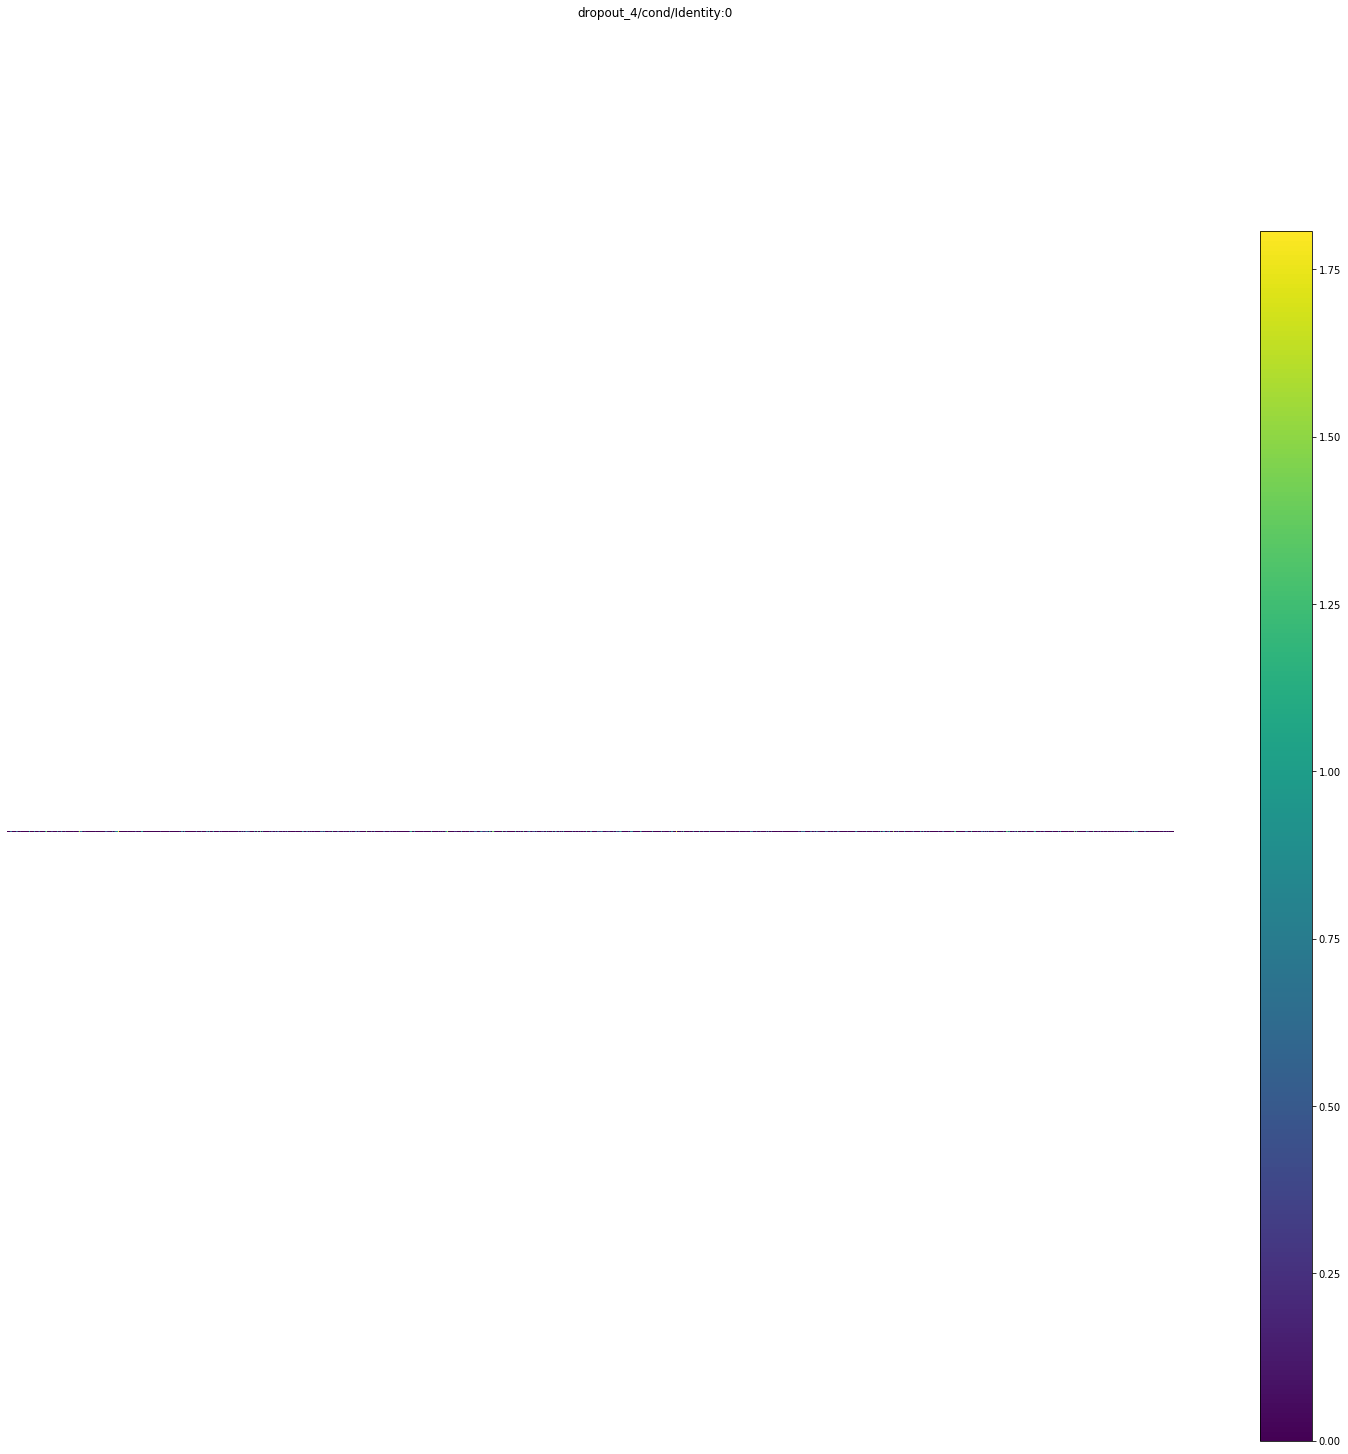

dense_2/Softmax:0 (1, 18) 


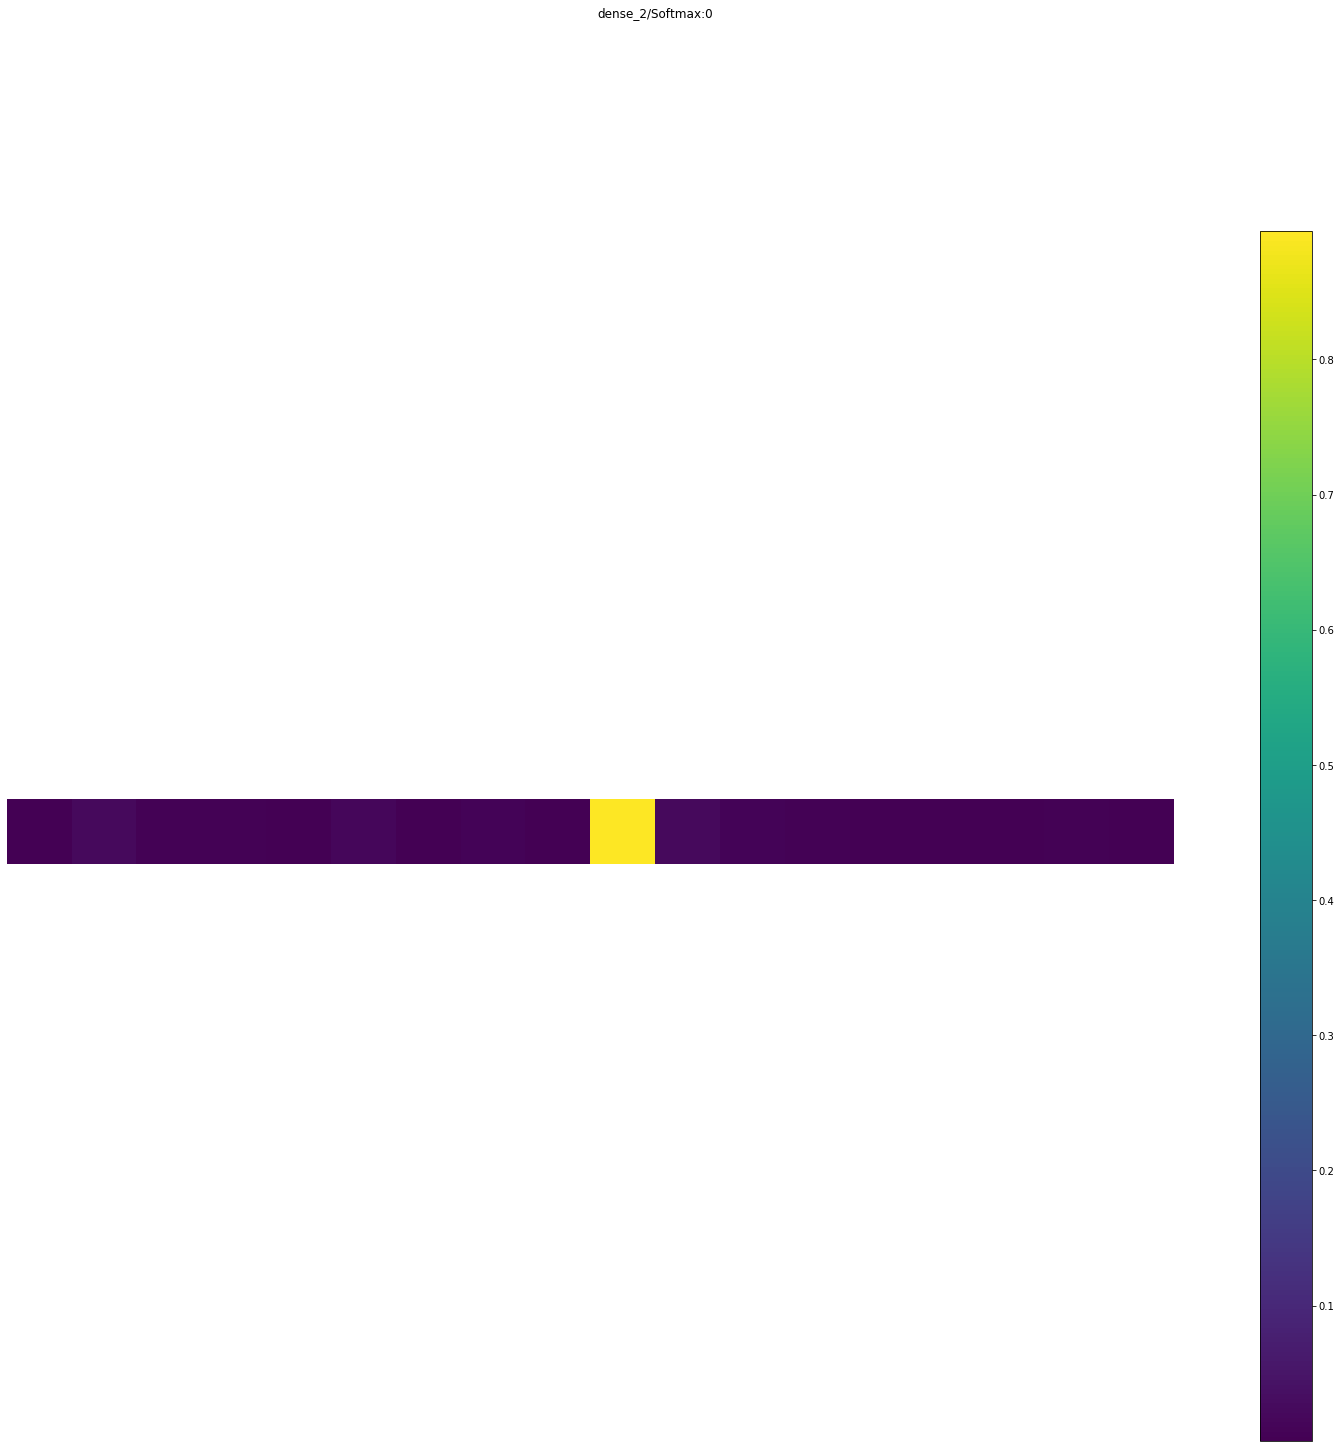

In [21]:
display_activations(activations, save=False)

NameError: name 'X' is not defined